In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold
from sklearn import preprocessing
!pip install optuna
import optuna
import xgboost as xgb
import functools
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

In [ ]:
api_token = {"username":"watsons","key":"dc7da47ca9aa5e696b65f97c16fd627b"}
import json
import zipfile
import os
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle competitions download -c house-prices-advanced-regression-techniques --force

In [126]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [127]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [128]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

In [129]:
y=np.log1p(train['SalePrice'])
train.drop(['SalePrice'],inplace=True,axis=1)
train_test=pd.concat([train,test])

In [130]:
total = train_test.isnull().sum().sort_values(ascending=False)
percent = (train_test.isnull().sum()/train_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total']>0]
missing_data['type'] = [train_test.dtypes[i] for i in missing_data.index]
missing_data

,Total,Percent,type
PoolQC,2909,0.996574,object
MiscFeature,2814,0.964029,object
Alley,2721,0.932169,object
Fence,2348,0.804385,object
FireplaceQu,1420,0.486468,object
LotFrontage,486,0.166495,float64
GarageCond,159,0.054471,object
GarageQual,159,0.054471,object
GarageYrBlt,159,0.054471,float64
GarageFinish,159,0.054471,object


In [131]:
for i in missing_data[(missing_data['Total']<5) & (missing_data['type']=='object')].index:
  train_test[i]=train_test[i].fillna(train_test[i].mode()[0])

In [132]:
for i in missing_data[(missing_data['Total']<5) & (missing_data['type']!='object')].index:
  train_test[i]=train_test[i].fillna(train_test[i].median())

In [133]:
train_test['MasVnrType']=train_test['MasVnrType'].fillna(train_test['MasVnrType'].mode()[0])
train_test['MasVnrArea']=train_test['MasVnrArea'].fillna(train_test['MasVnrArea'][train_test['MasVnrType']=='None'].median())

In [134]:
print(train_test['LotFrontage'][train['Street']=='Grvl'].describe())
print(train_test['LotFrontage'][train['Street']=='Pave'].describe())
train_test['LotFrontage']=train_test['LotFrontage'].fillna(train_test['LotFrontage'].median())

count      8.00000
mean      75.87500
std       31.49348
min       21.00000
25%       62.00000
50%       79.50000
75%       88.25000
max      120.00000
Name: LotFrontage, dtype: float64
count    2425.000000
mean       69.284124
std        23.319007
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


In [135]:
#刪去類別間不顯著的類別變數
train_test.drop(['GarageYrBlt','LandSlope','YrSold'],axis=1,inplace=True)
train_test.fillna('thena',inplace=True)

In [136]:
train_test.drop(missing_data.index[:5],inplace=True,axis=1)
train_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,Attchd,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,WD,Normal
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,Attchd,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,WD,Normal
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,Attchd,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,WD,Normal
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Detchd,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,0,2,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,Attchd,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,0,12,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,thena,thena,0.0,0.0,thena,thena,Y,0,0,0,0,0,0,0,6,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,CarPort,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,Detchd,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,thena,thena,0.0,0.0,thena,thena,Y,80,32,0,0,0,0,700,7,WD,Normal


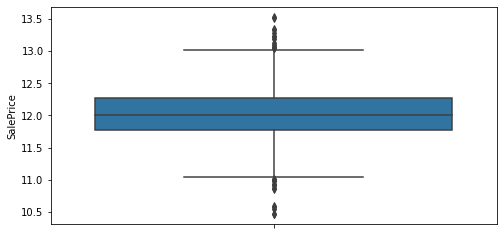

In [137]:
f, ax = plt.subplots(figsize=(8,4))
fig = sns.boxplot(y=y)

In [138]:
train_test['YearBuilt']=[2020-i for i in train_test['YearBuilt']]
train_test['YearRemodAdd']=[2020-i for i in train_test['YearRemodAdd']]

In [139]:
train_test['totalsf']=train_test['1stFlrSF']+train_test['2ndFlrSF']+train_test['TotalBsmtSF']
train_test['totalporch']=train_test['EnclosedPorch']+train_test['OpenPorchSF']+train_test['ScreenPorch']+train_test['3SsnPorch']
train_test['Total_Bathrooms'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) +train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

train_test['PoolArea_0'] = train_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['BsmtFinSF1_0'] = train_test['BsmtFinSF1'].apply(lambda x: 1 if x > 0 else 0)
train_test['2ndFlrSF_0'] = train_test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train_test['WoodDeckSF_0'] = train_test['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train_test['OpenPorchSF_0'] = train_test['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train_test['EnclosedPorch_0'] = train_test['EnclosedPorch'].apply(lambda x: 1 if x > 0 else 0)
train_test['ScreenPorch_0'] = train_test['ScreenPorch'].apply(lambda x: 1 if x > 0 else 0)
train_test['BsmtFinSF2_0'] = train_test['BsmtFinSF2'].apply(lambda x: 1 if x > 0 else 0)
train_test['3SsnPorch_0'] = train_test['3SsnPorch'].apply(lambda x: 1 if x > 0 else 0)


In [140]:
data=pd.concat([train_test[:1460],y],axis=1)

In [141]:
intlist=['LotFrontage','LotArea','YearRemodAdd','YearBuilt','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','totalsf','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch','totalporch','Total_Bathrooms',]
len(intlist)

19

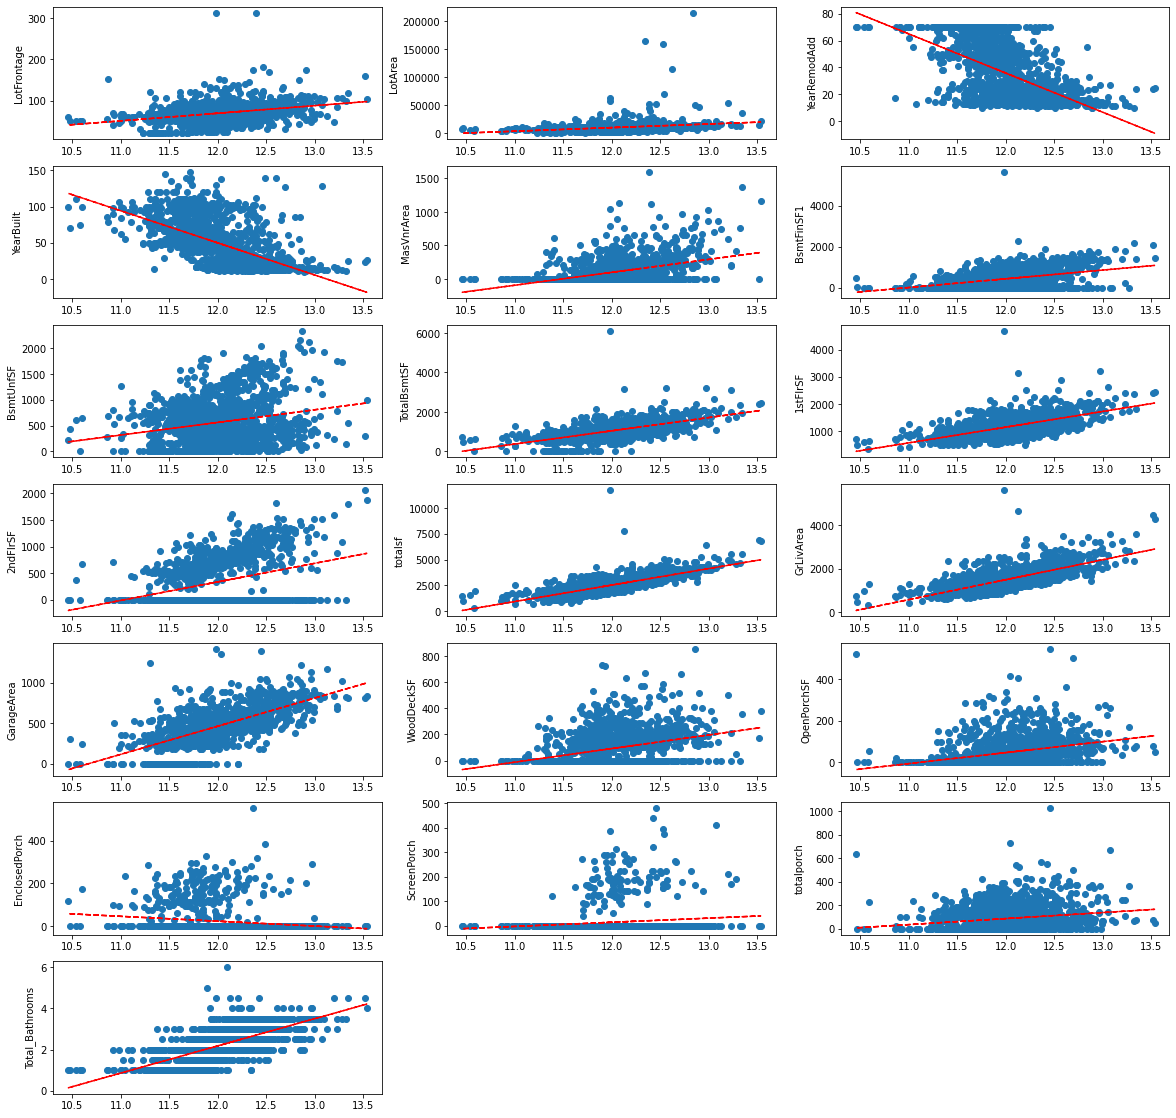

In [142]:
import pylab
plt.figure(figsize=(20,20))
for idx,col in enumerate(intlist):
  plt.subplot(7,3,idx+1)    
  var=col
  pylab.plot(y,data[var],'o')
  z = np.polyfit(y,data[var],1)
  p = np.poly1d(z)
  pylab.plot(y,p(y),'r--')
  pylab.ylabel(var)

In [143]:
#因其散佈圖與標籤無明顯關係故刪去該群連續變數
train_test.drop(['BsmtFinSF2','LowQualFinSF','3SsnPorch','PoolArea','MiscVal','Id'],axis=1,inplace=True)

In [144]:
catlist = list(set(train_test.columns).difference(set(intlist)))
len(catlist)

59

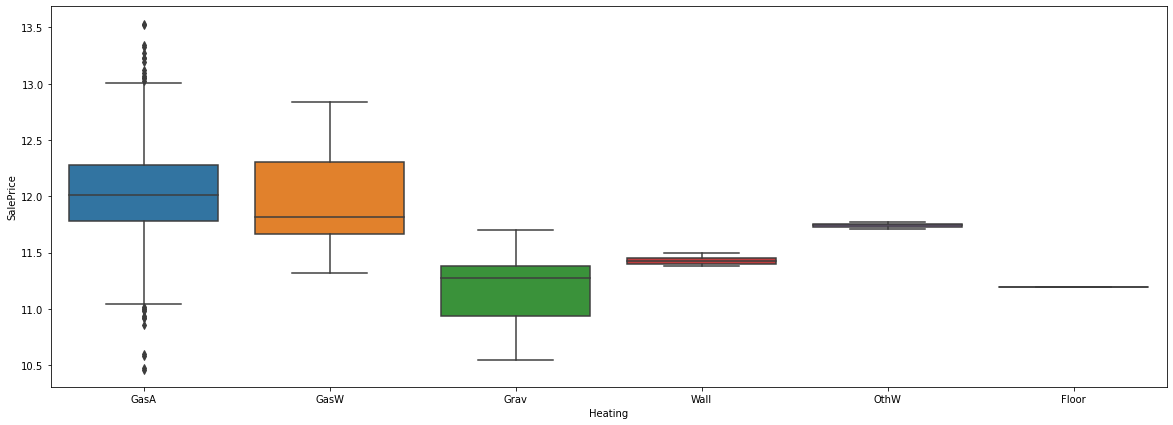

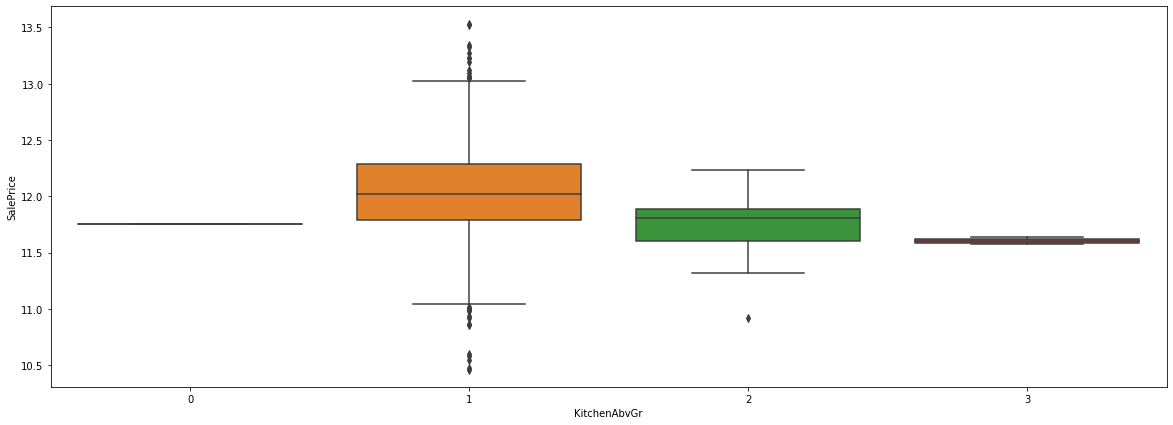

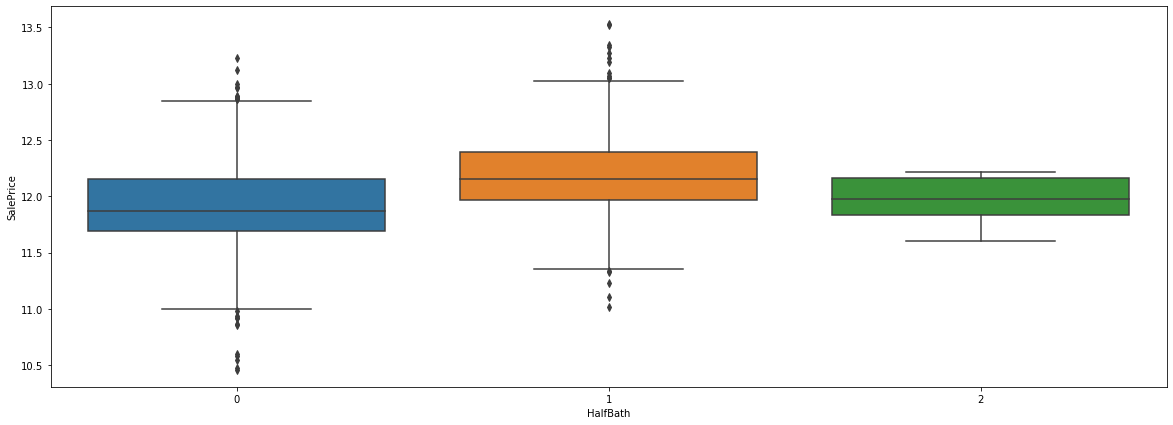

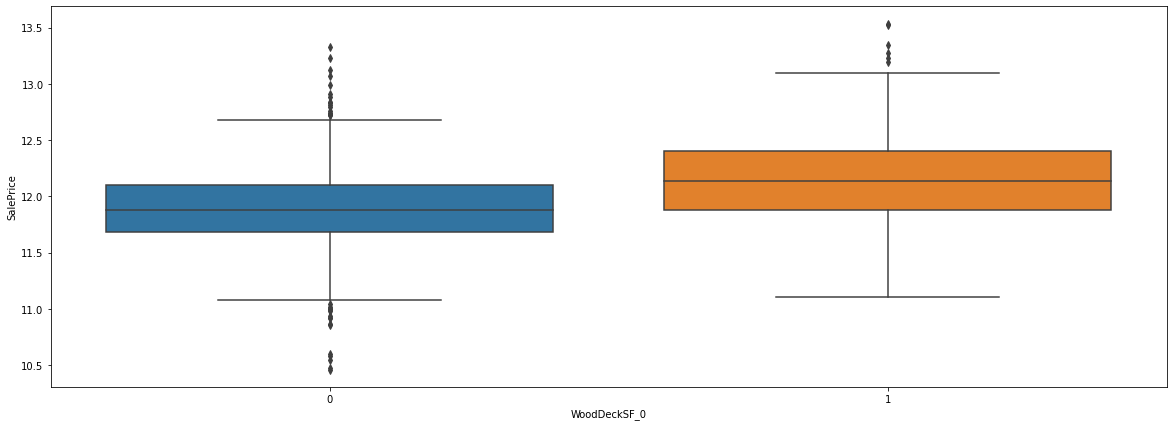

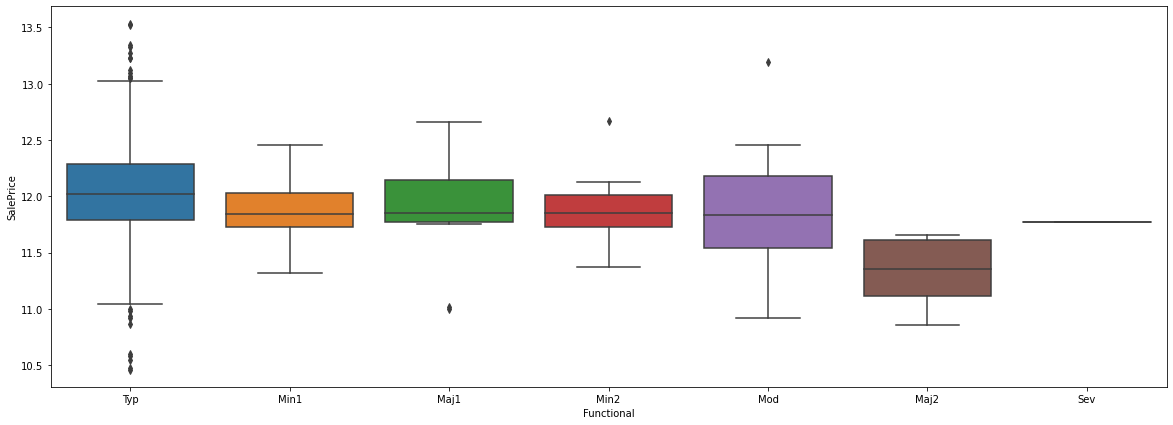

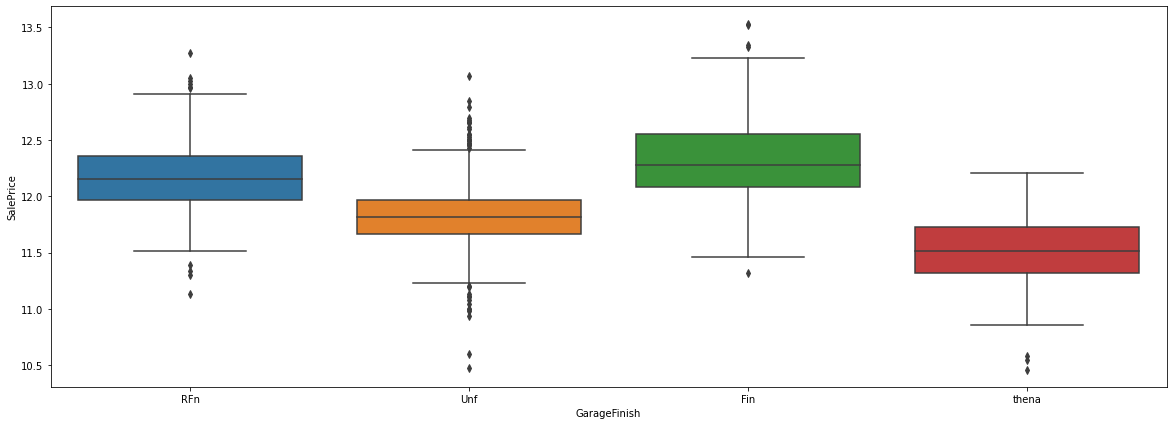

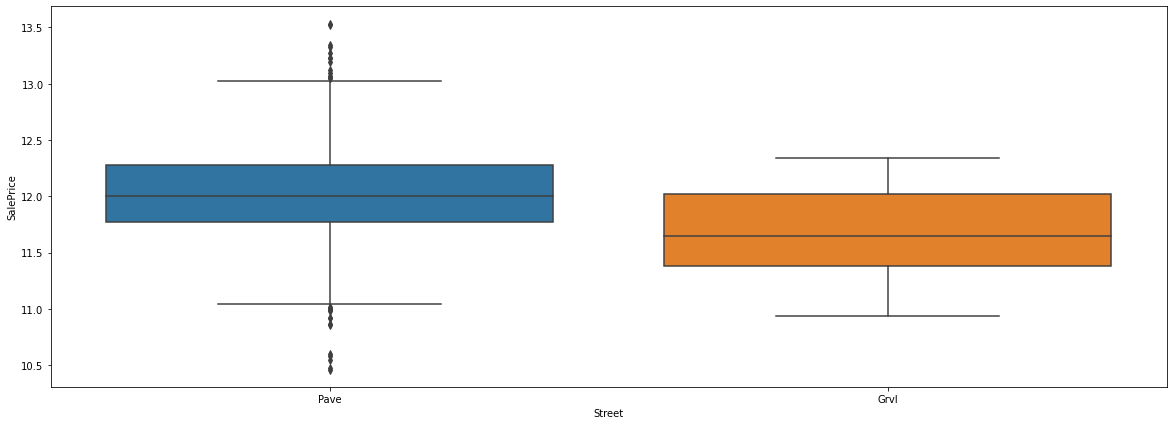

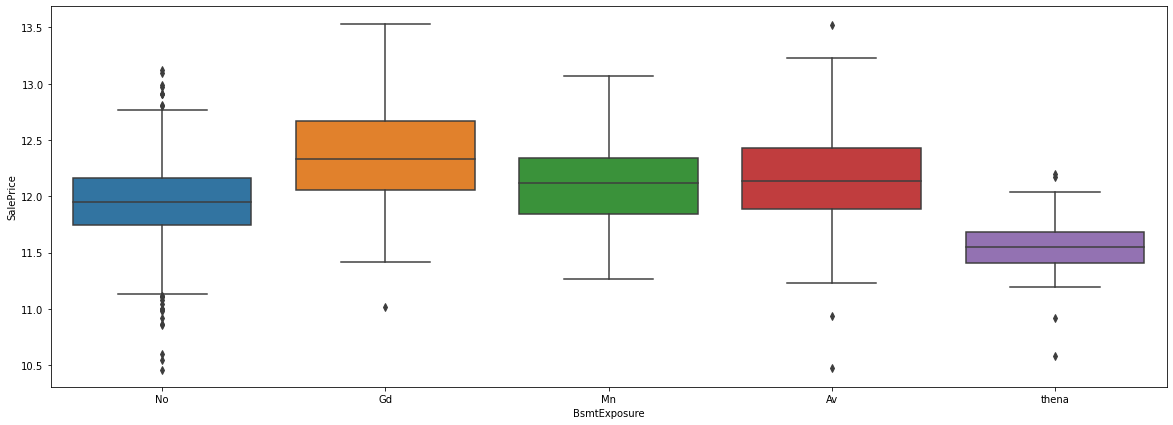

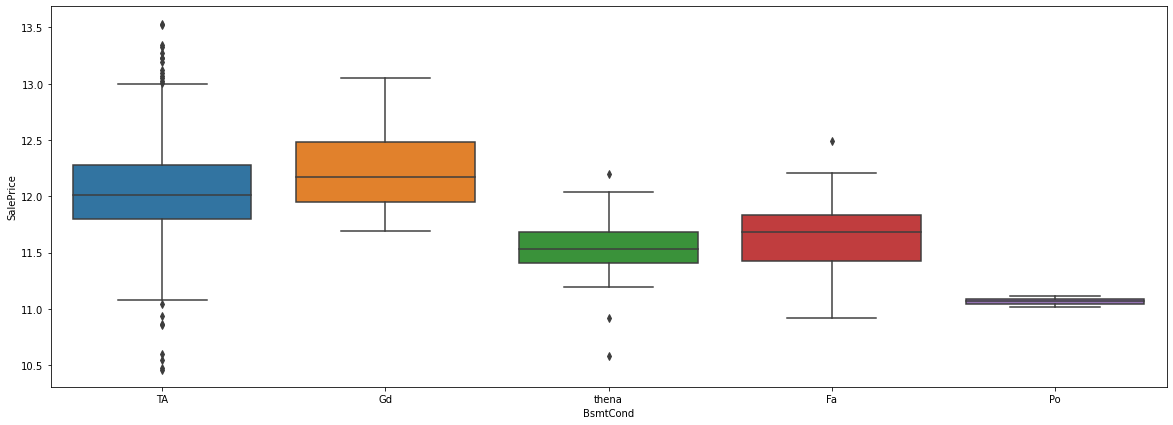

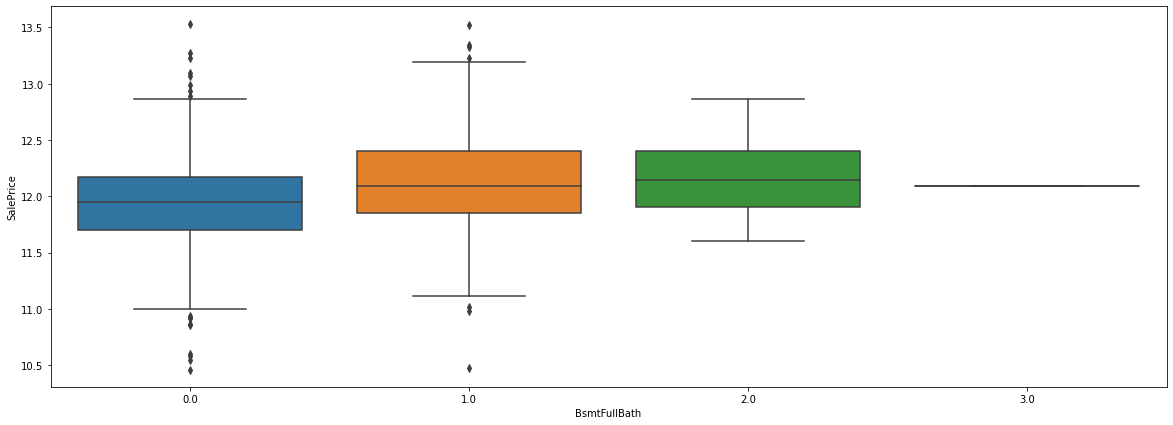

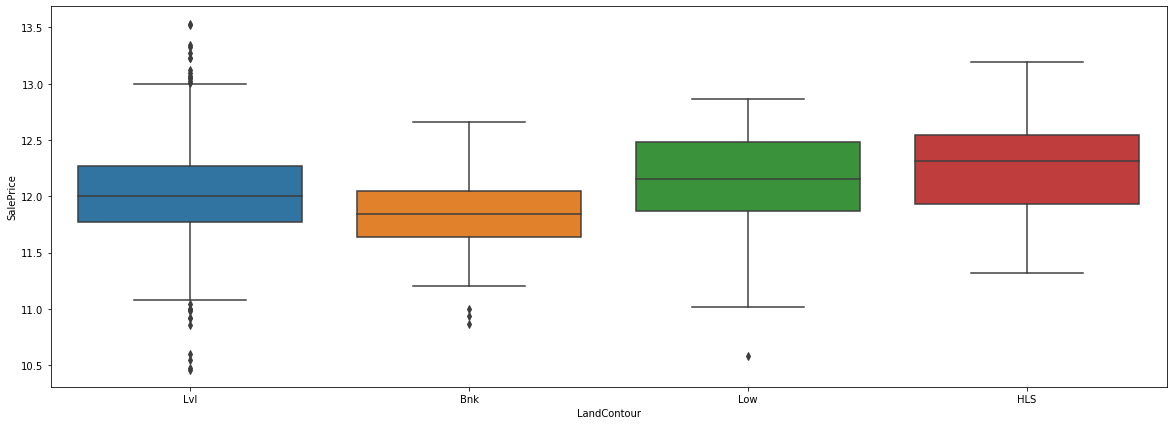

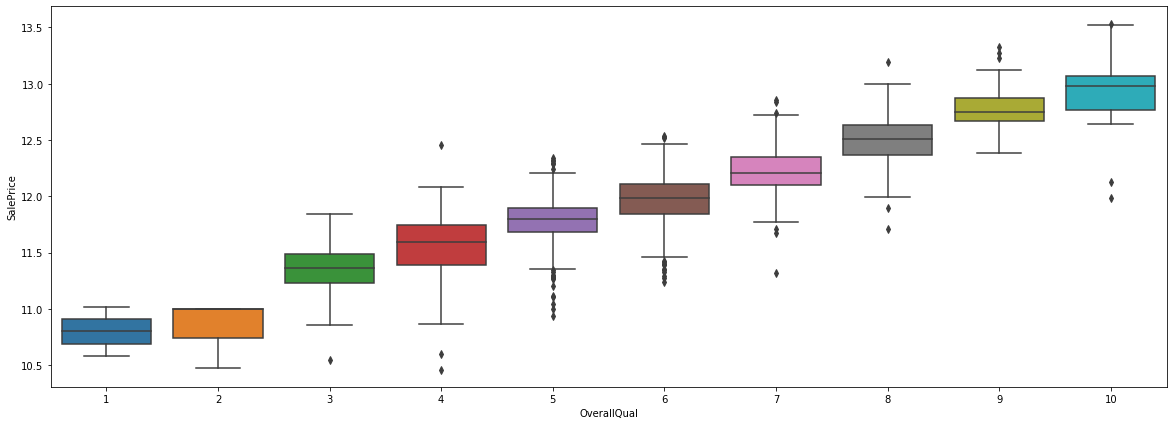

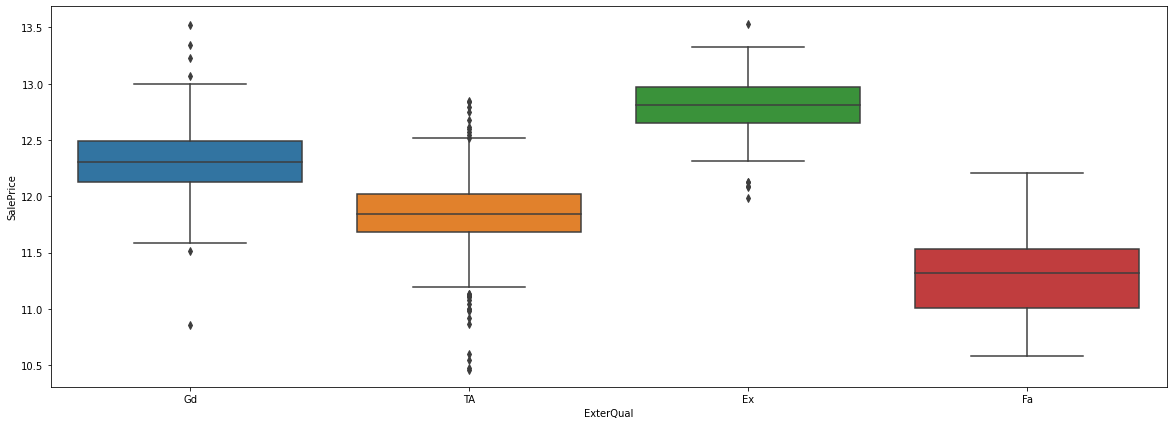

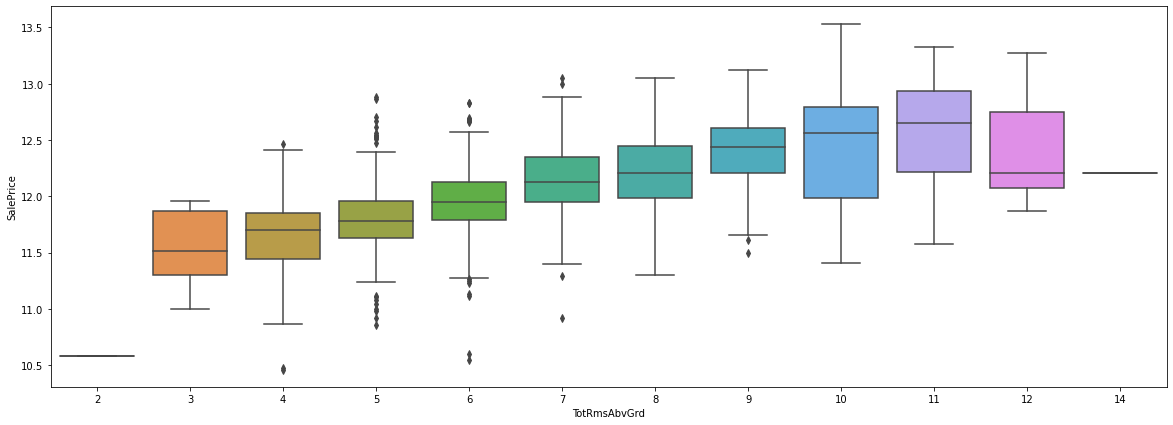

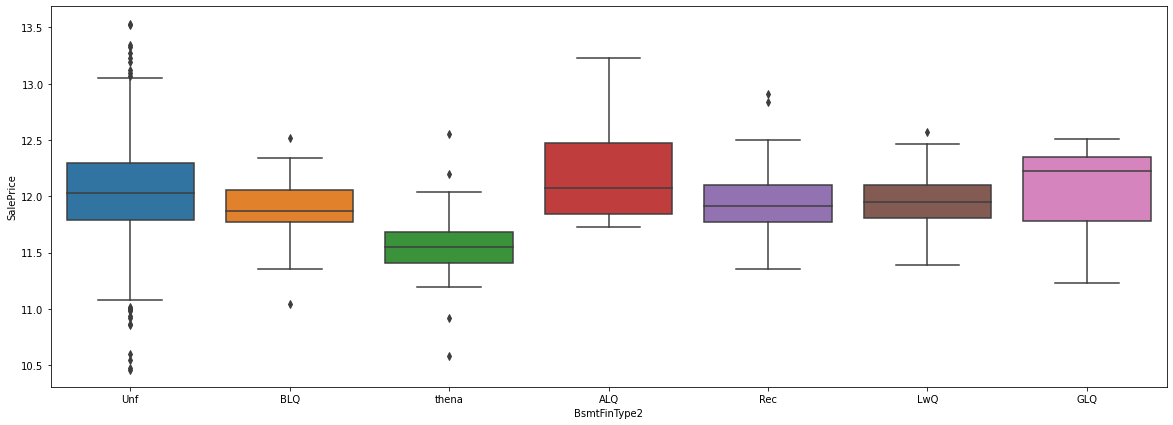

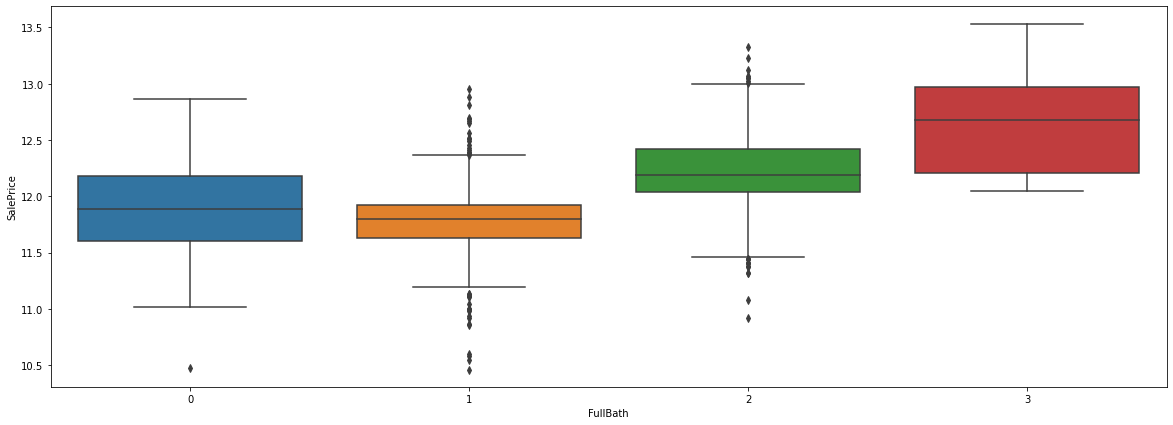

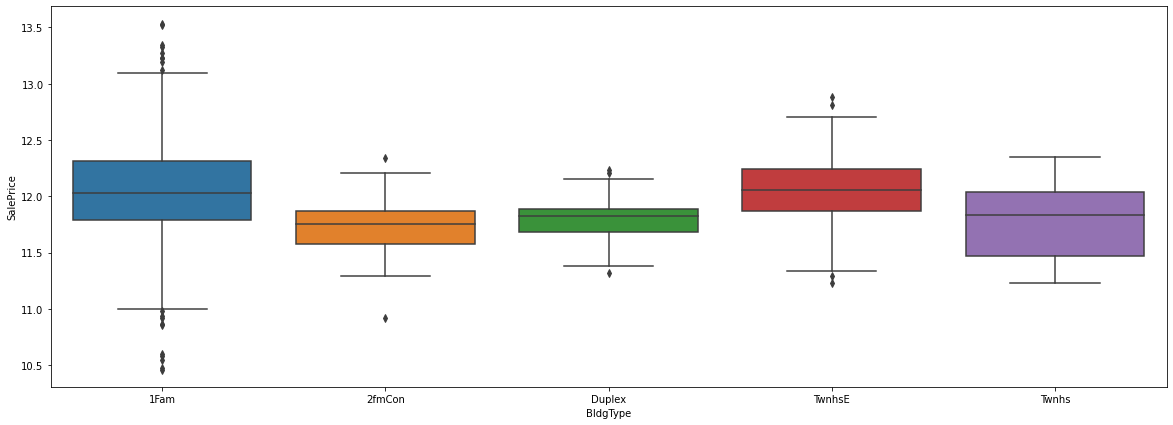

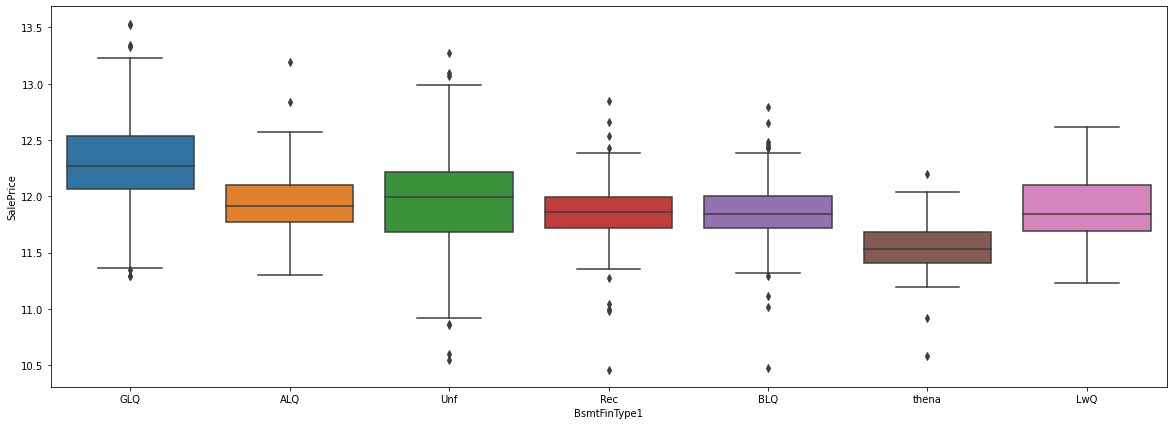

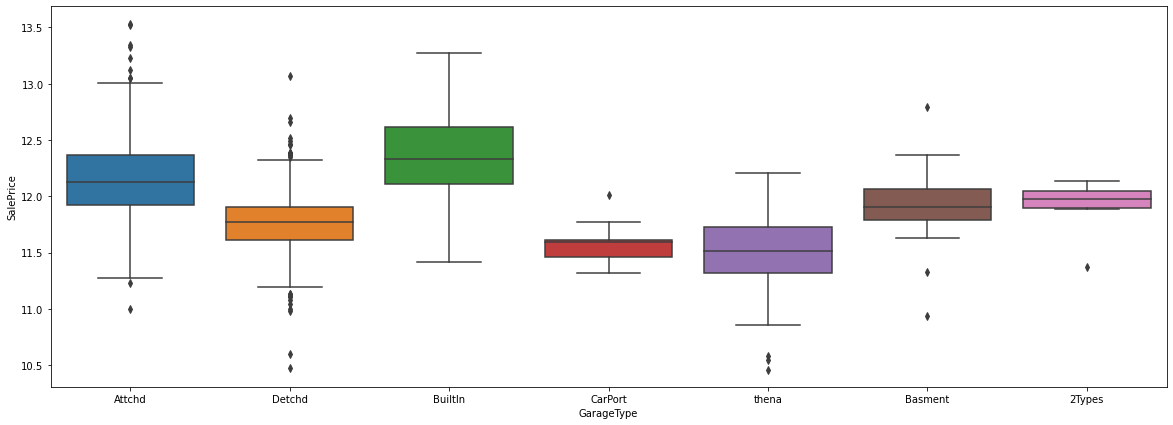

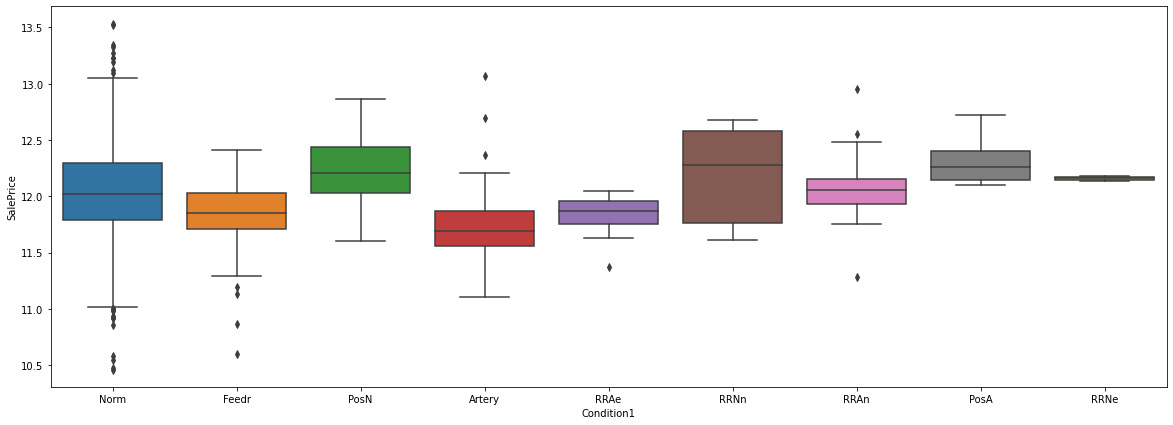

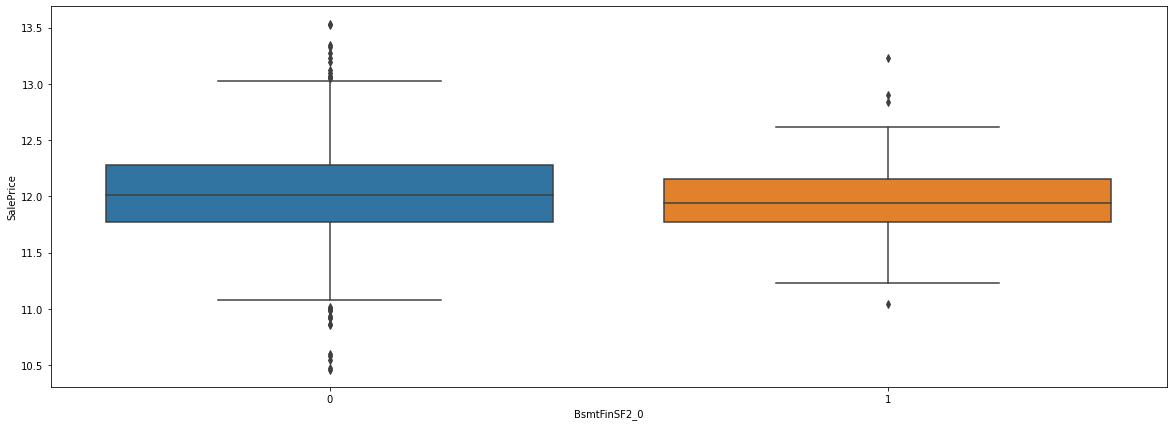

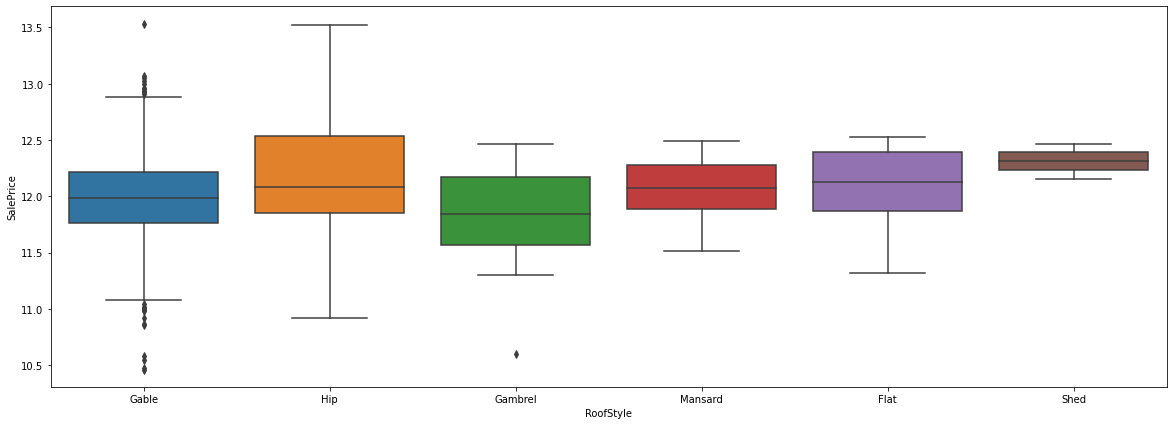

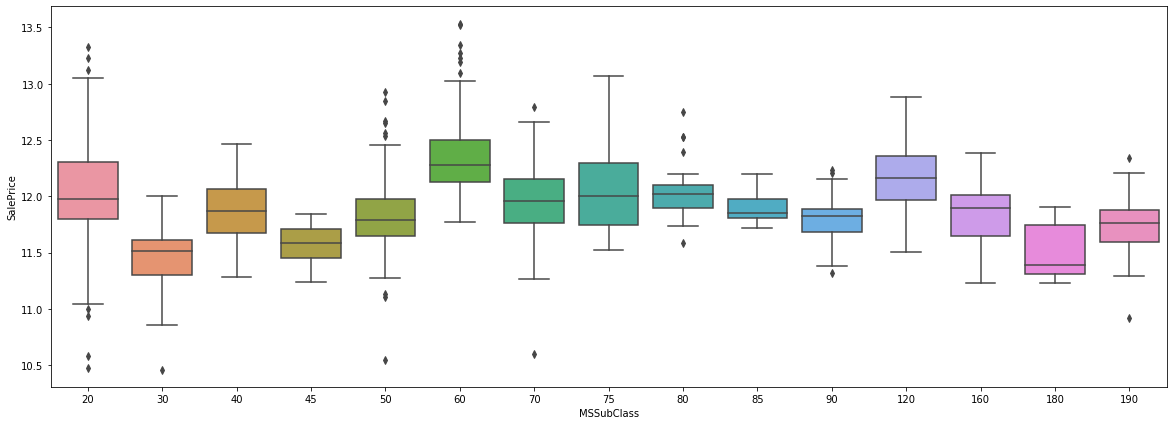

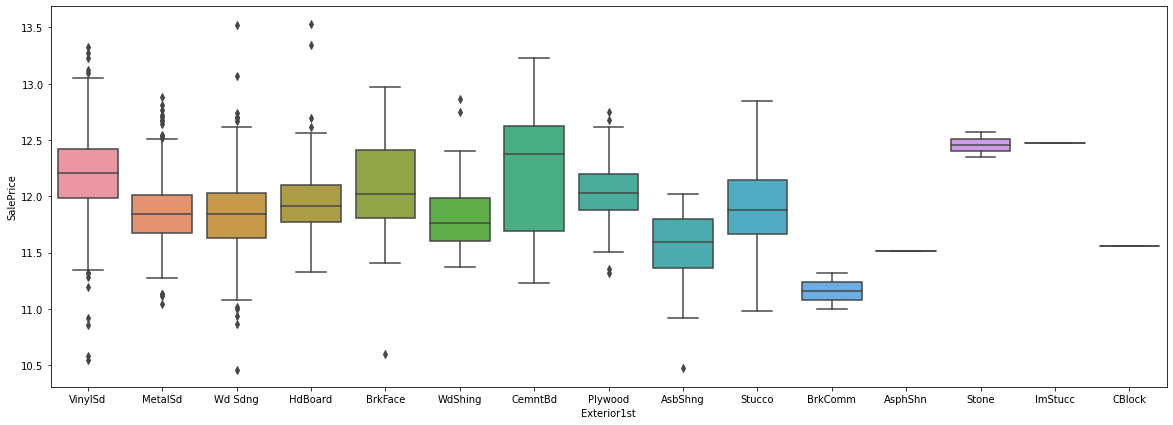

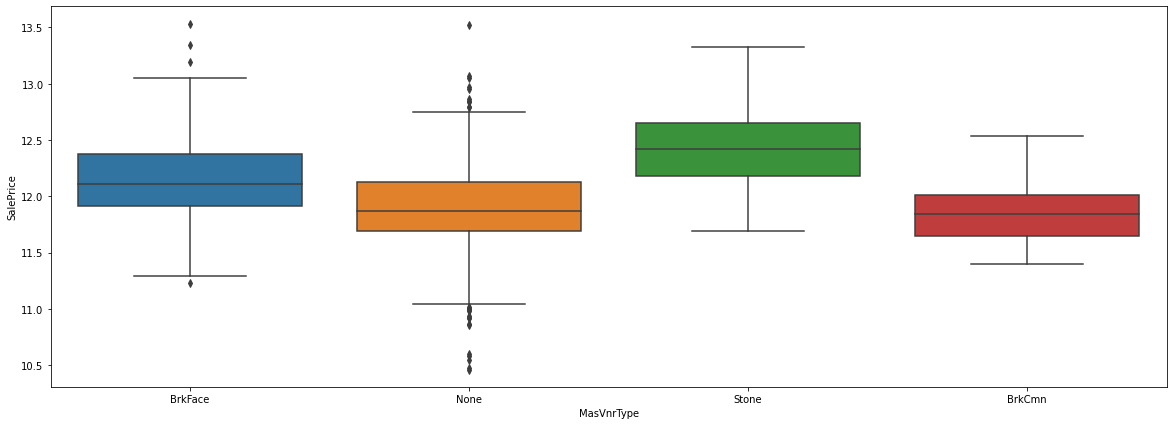

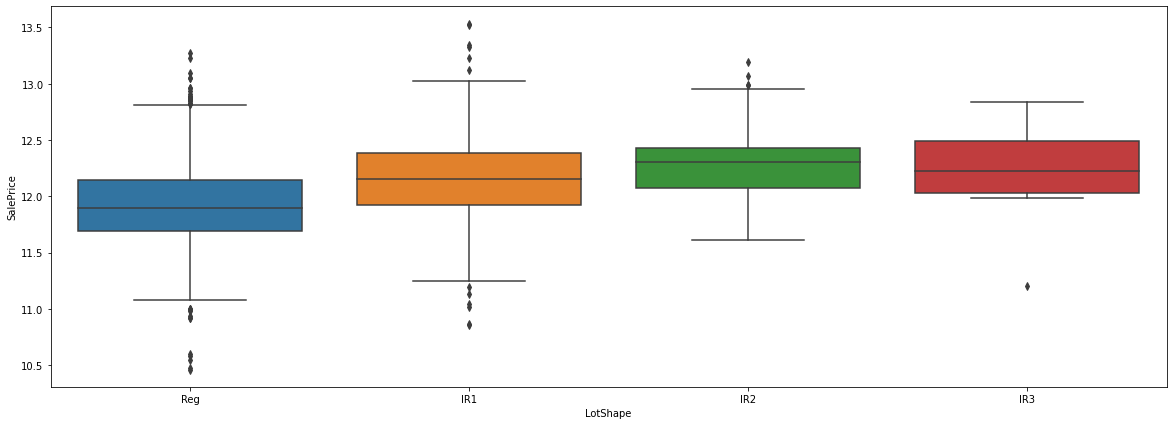

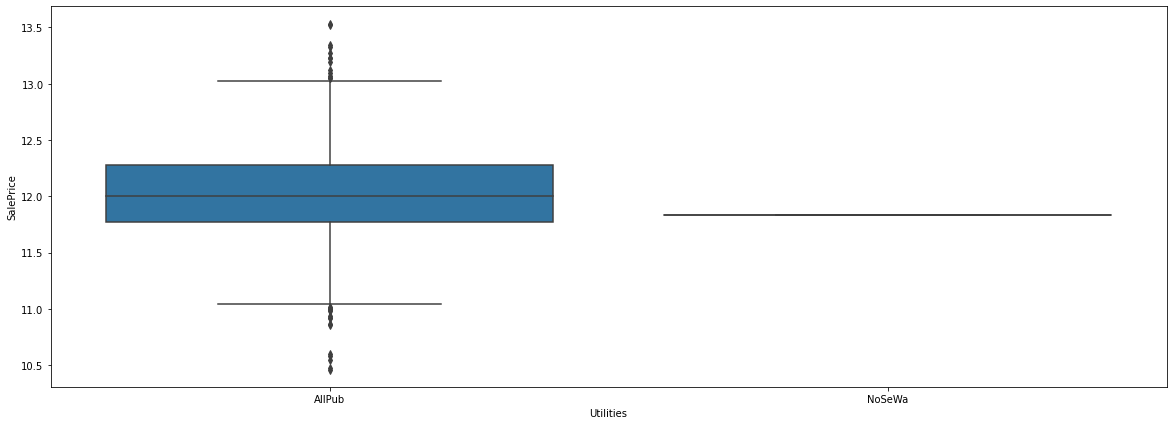

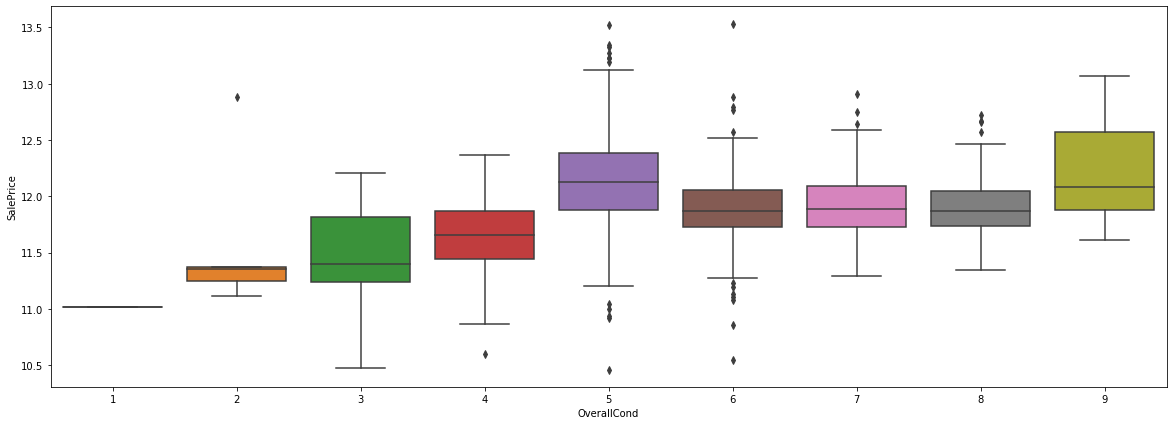

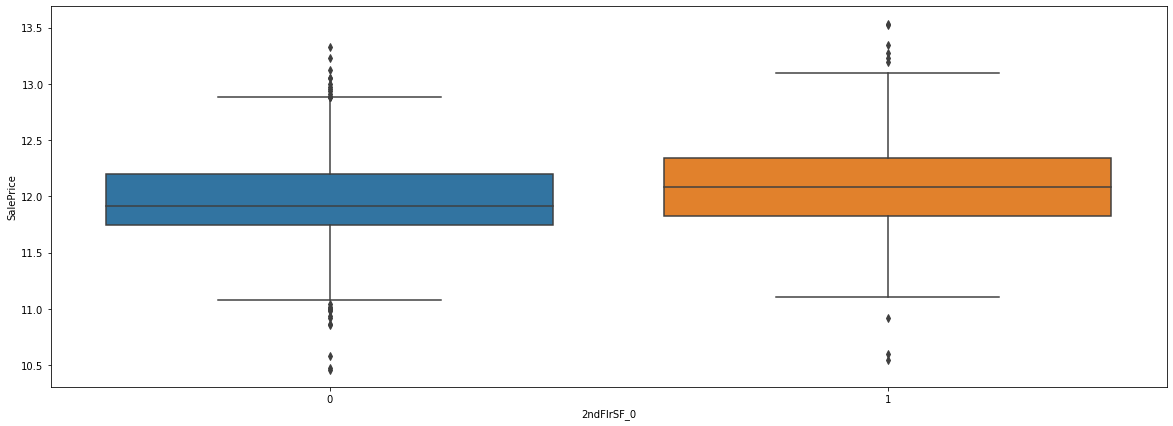

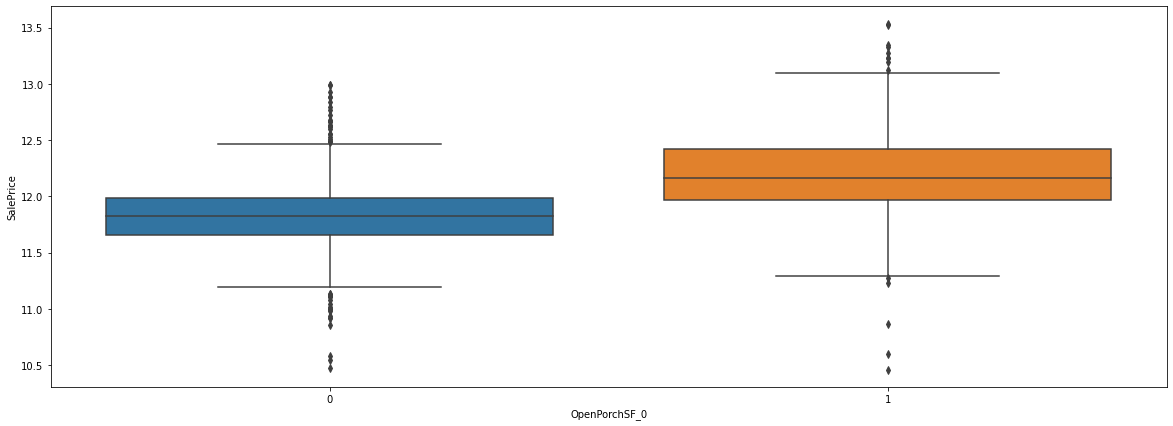

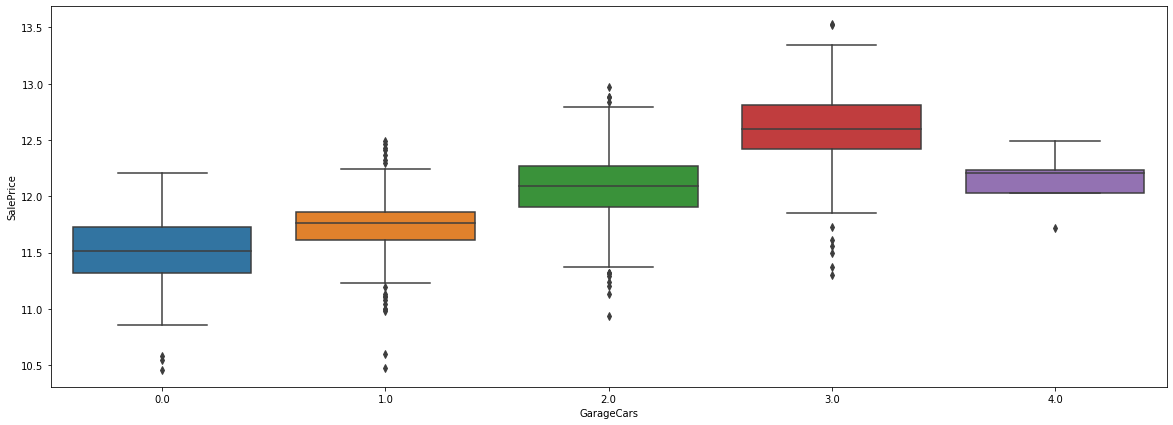

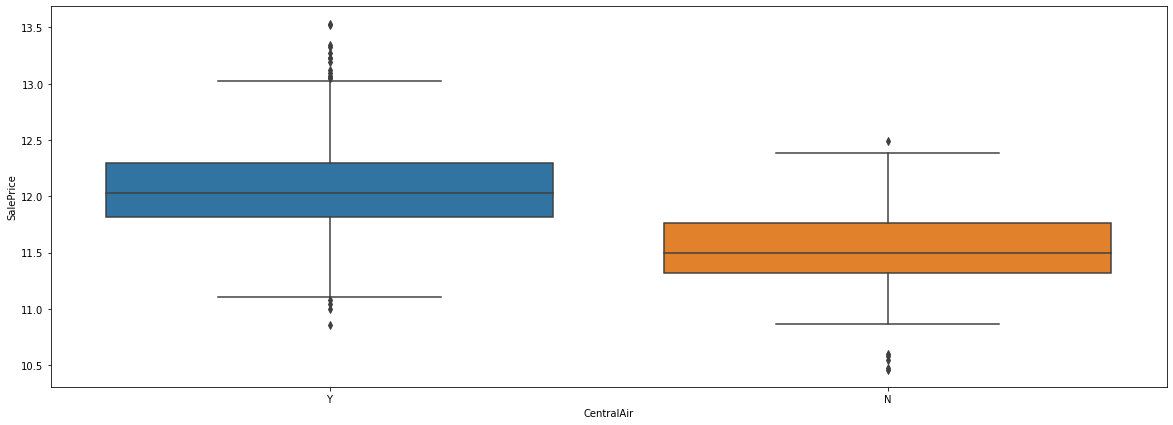

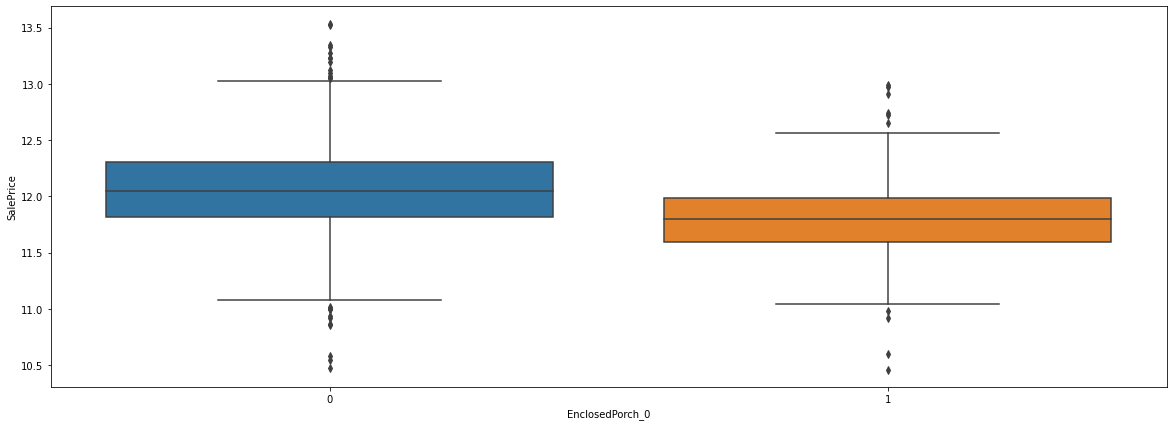

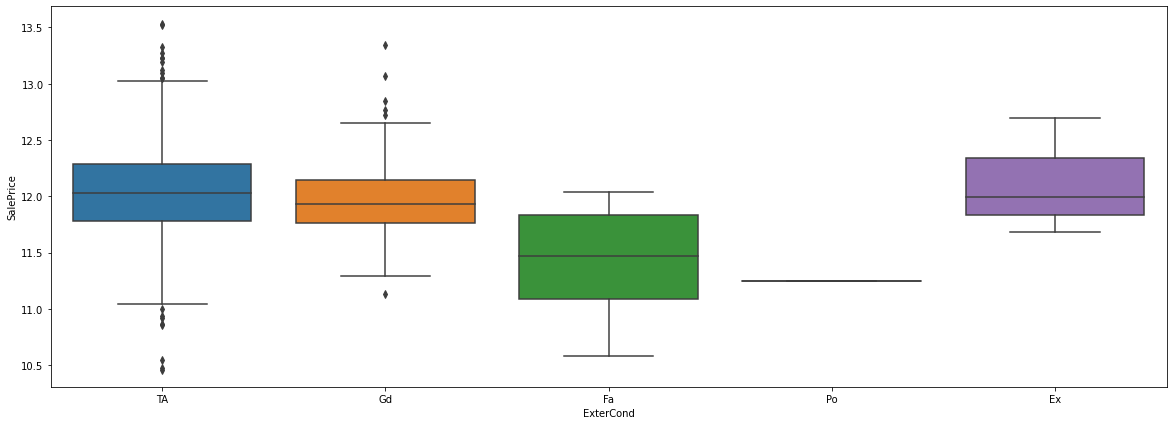

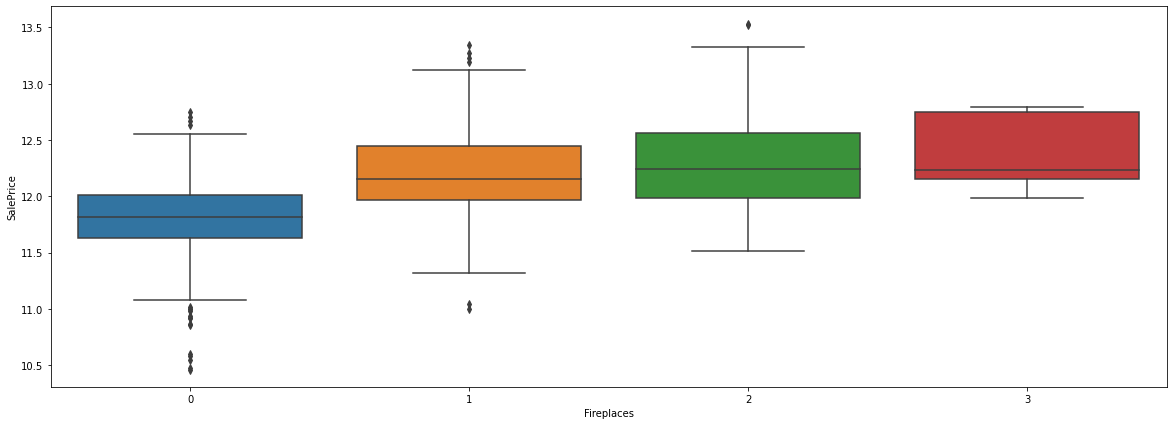

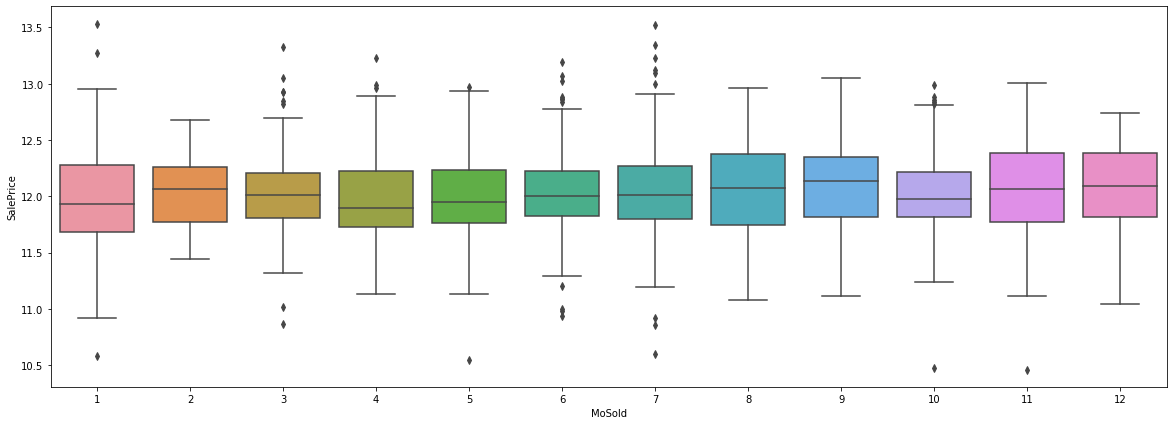

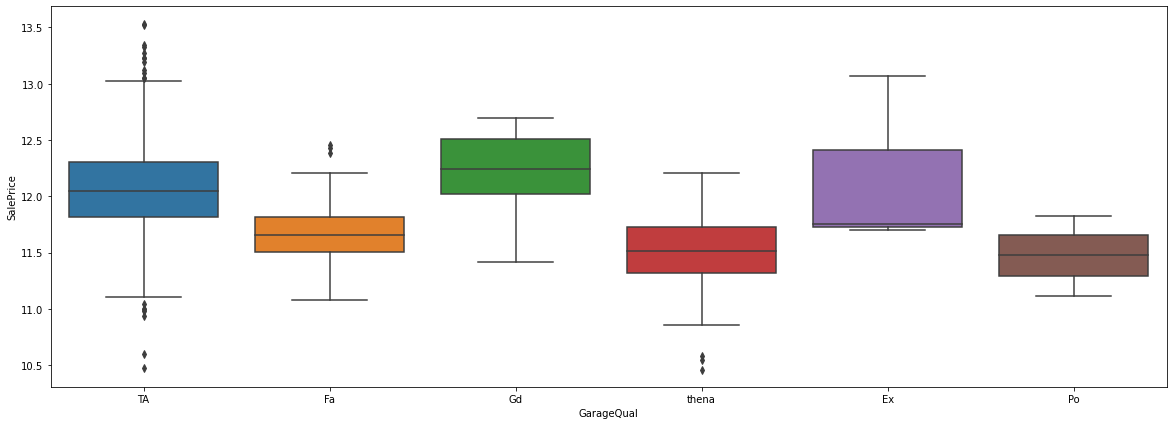

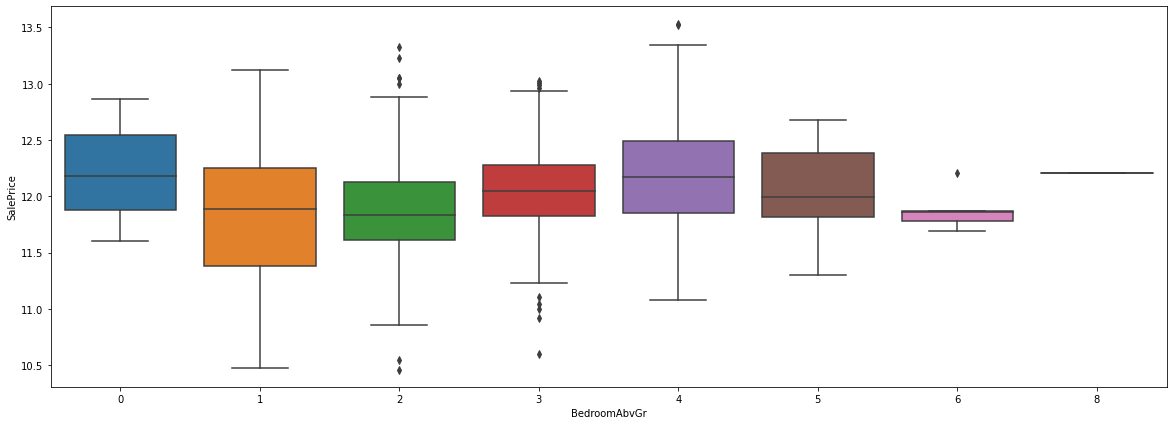

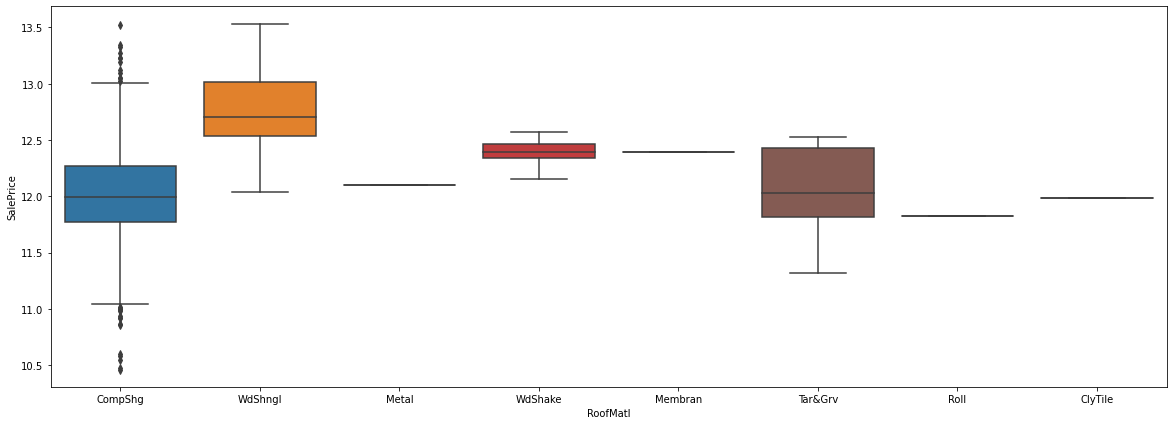

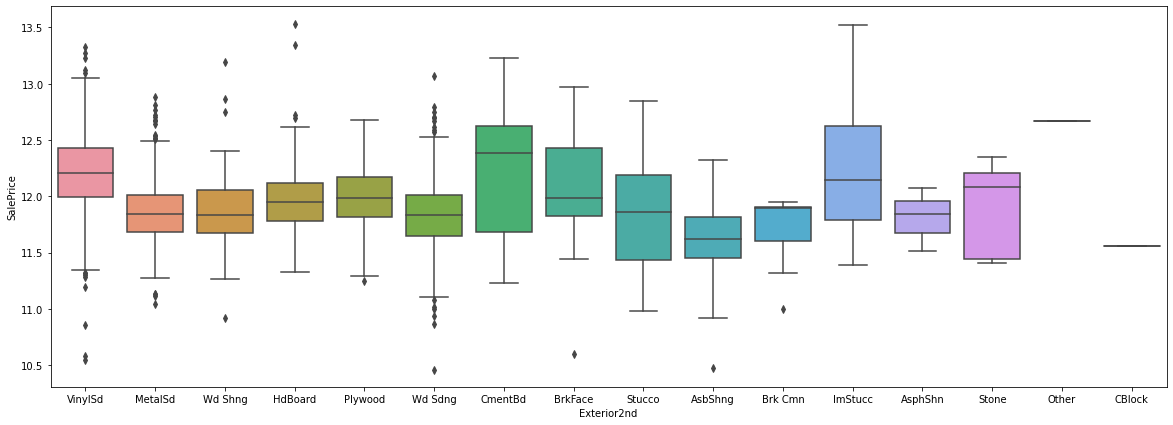

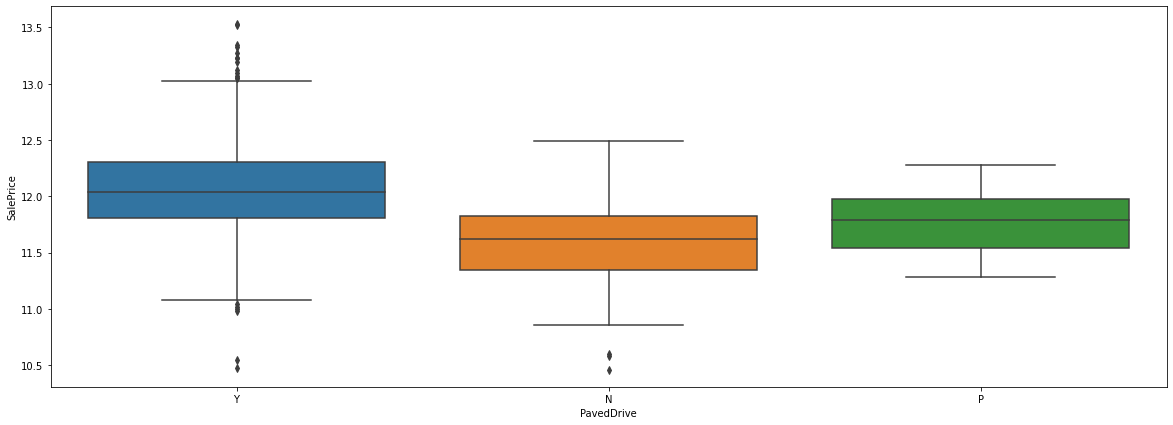

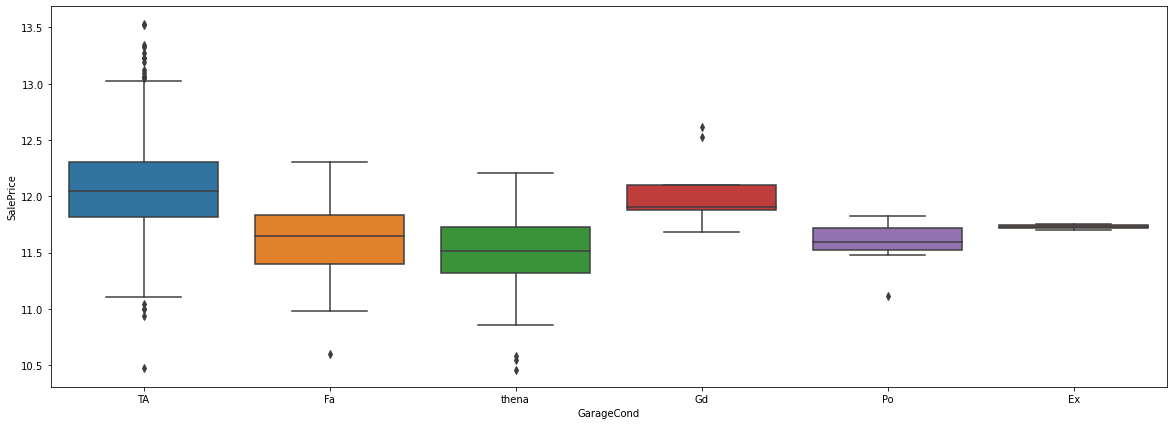

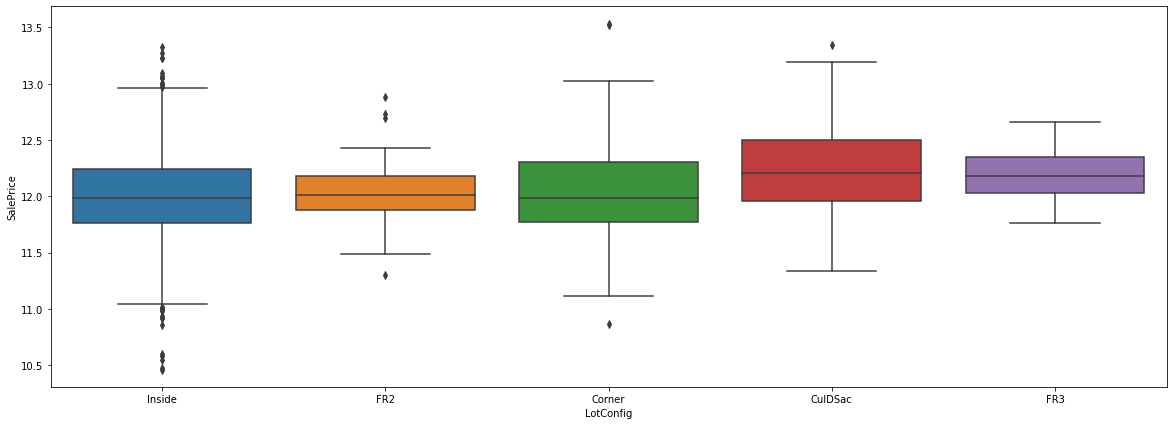

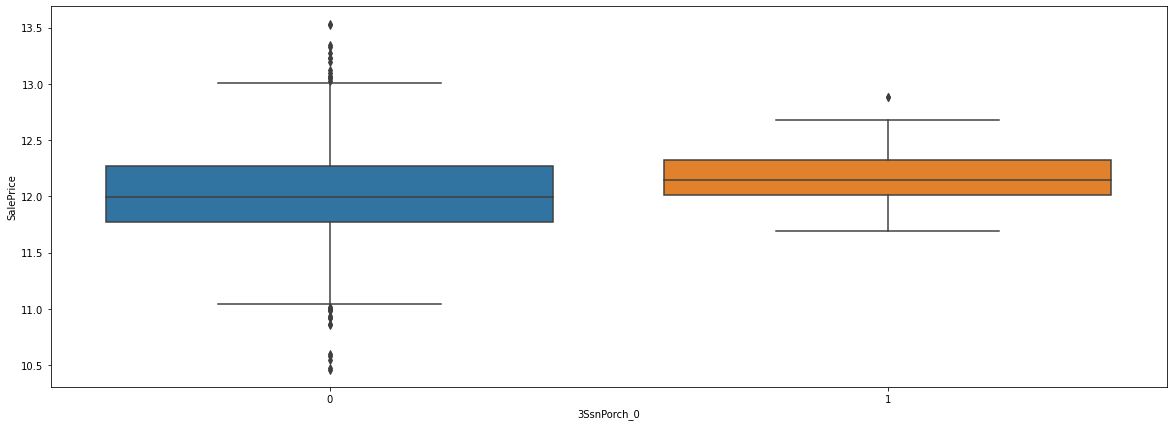

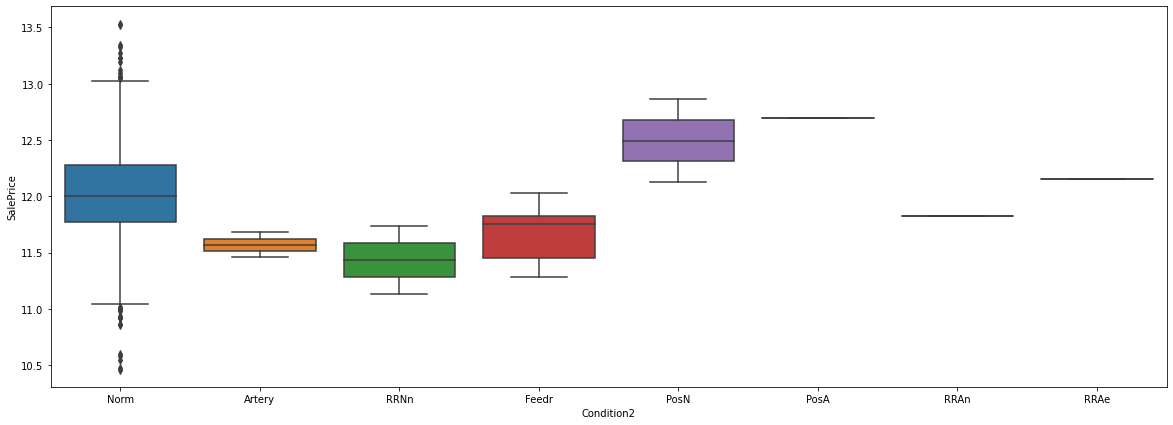

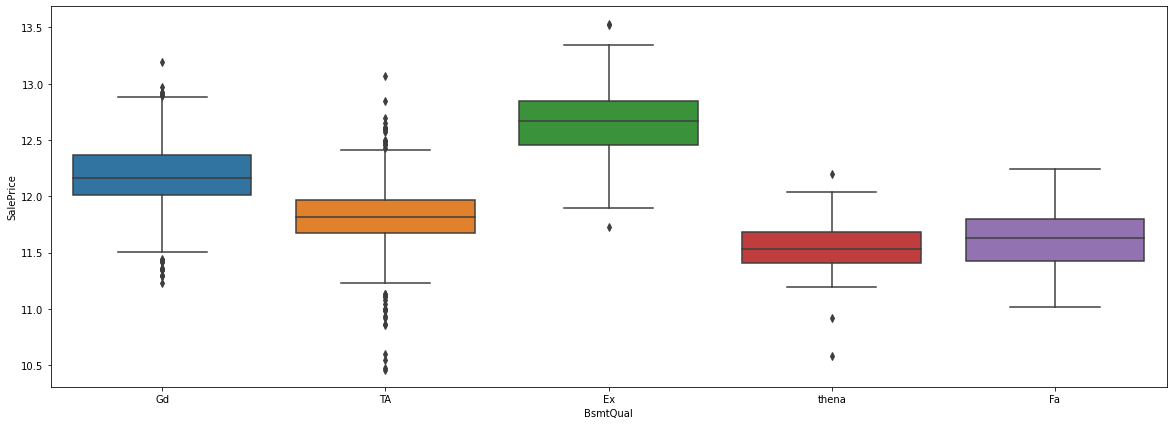

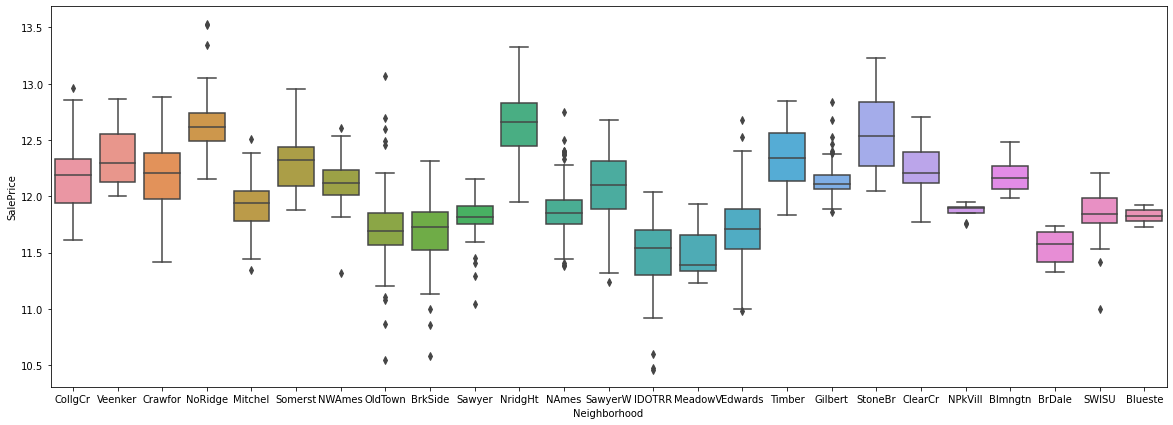

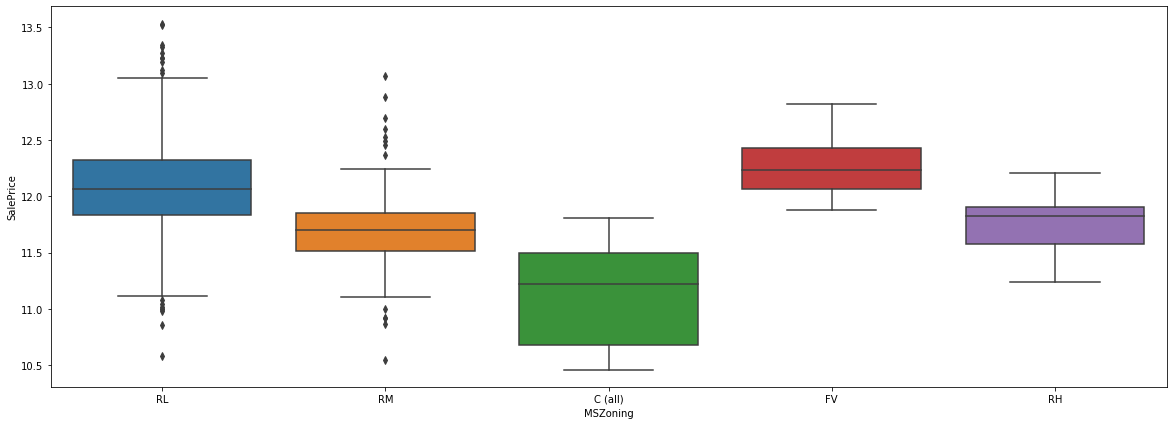

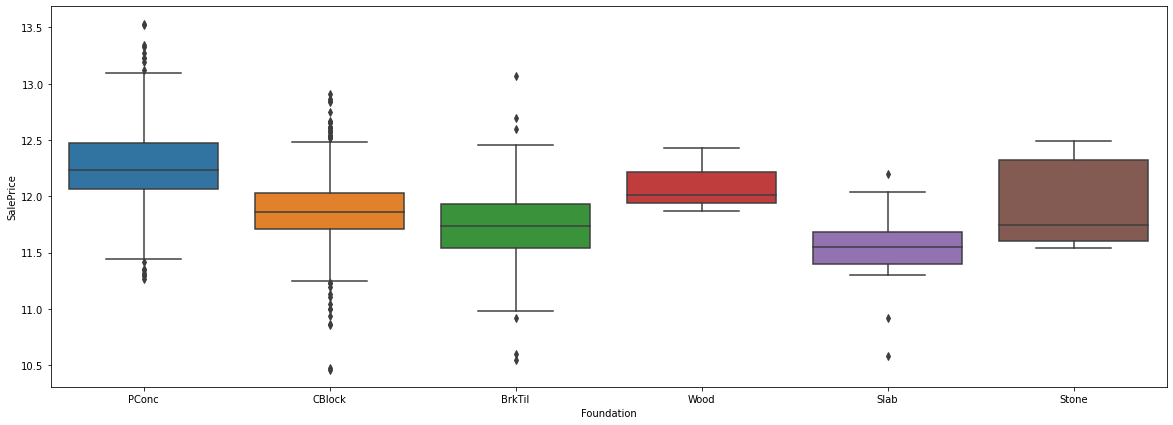

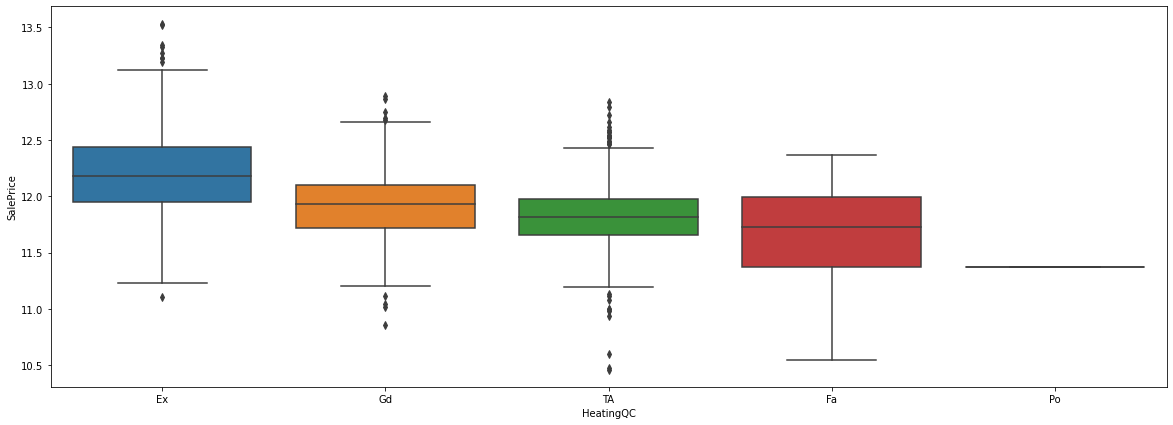

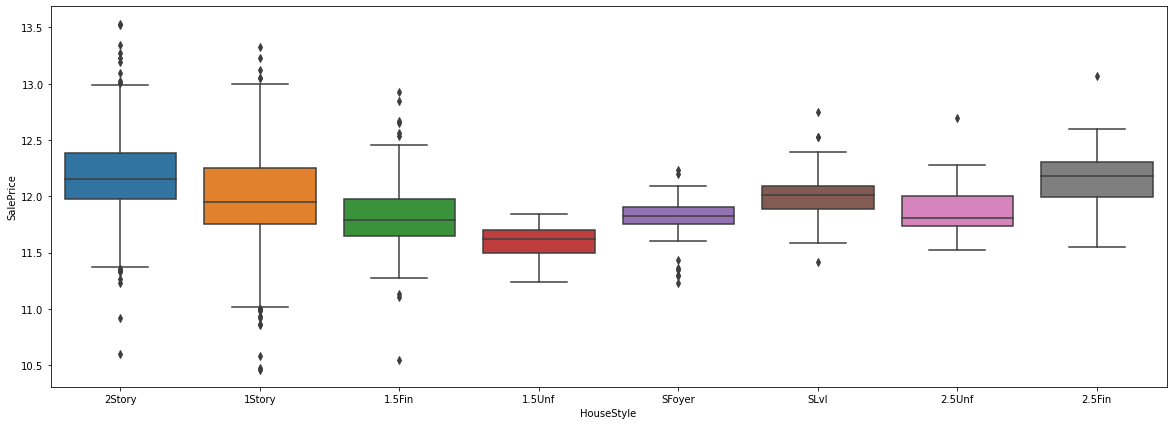

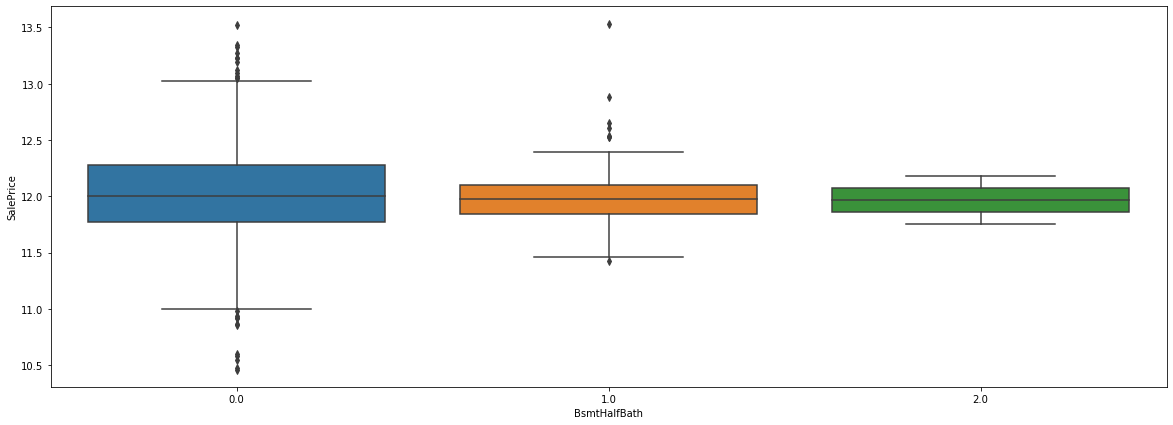

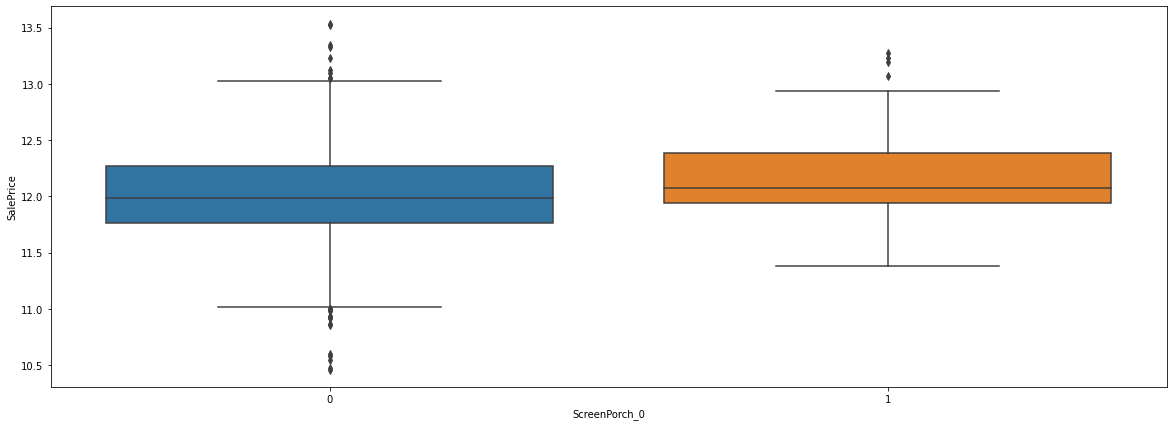

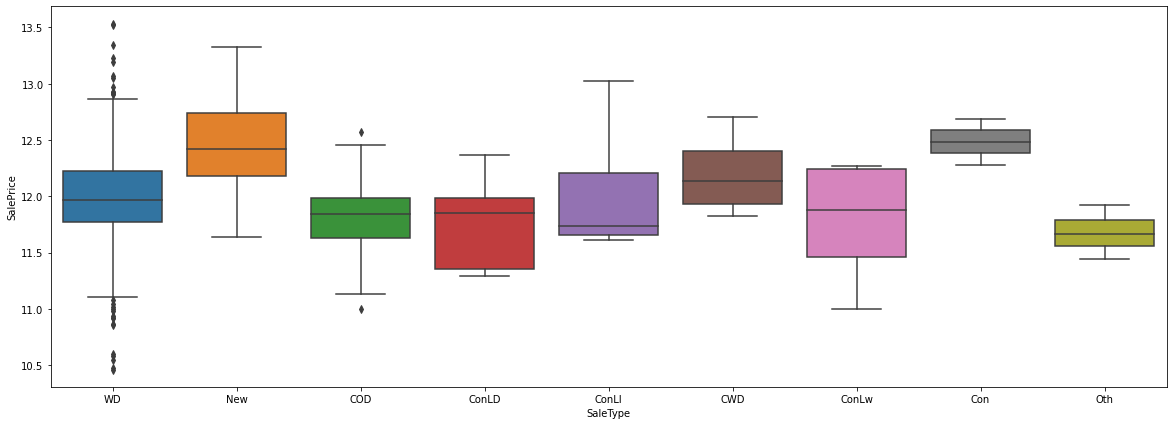

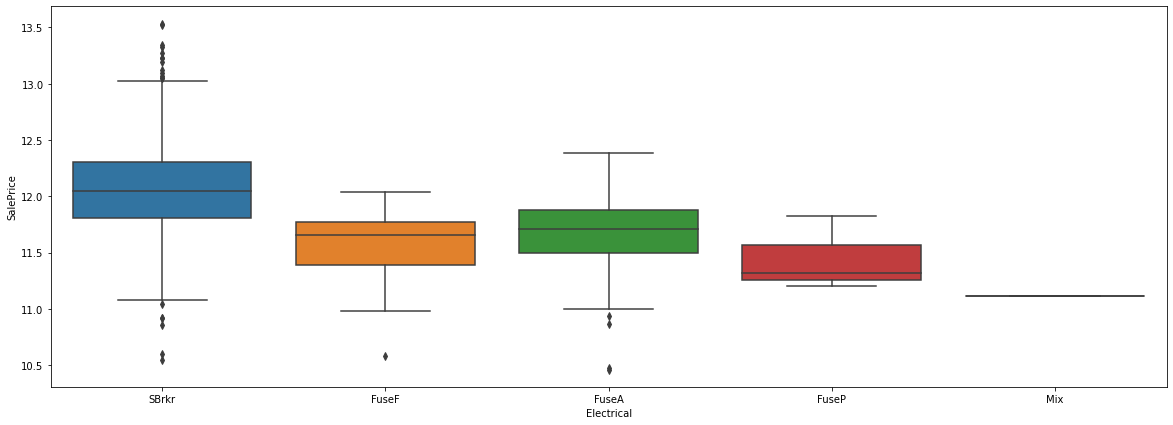

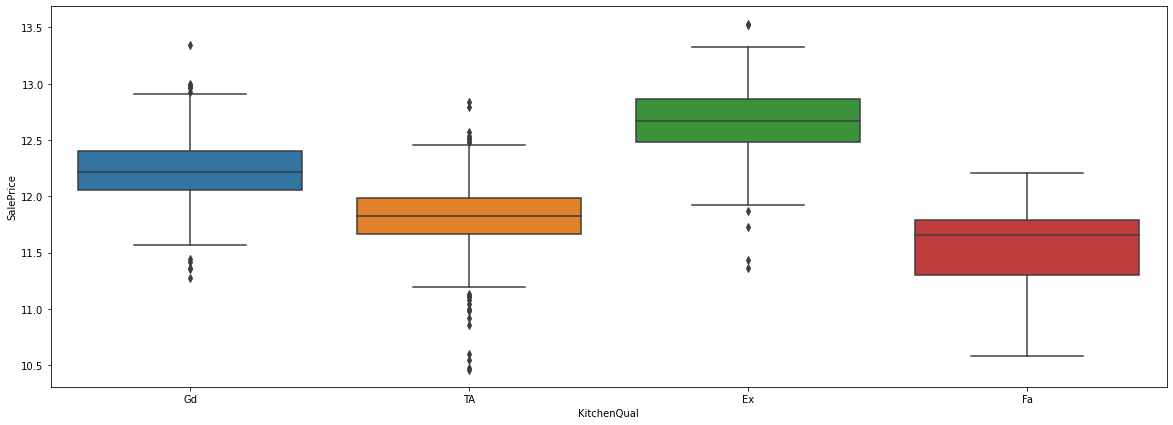

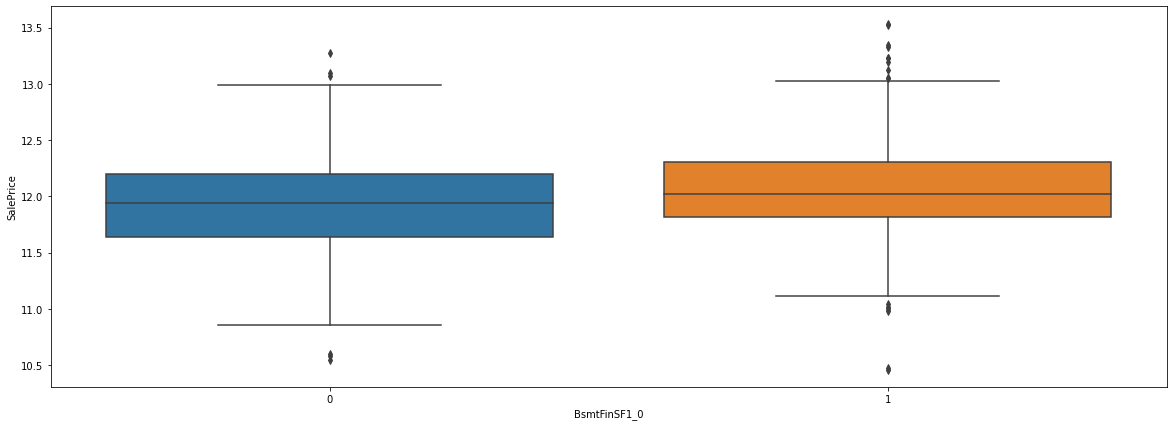

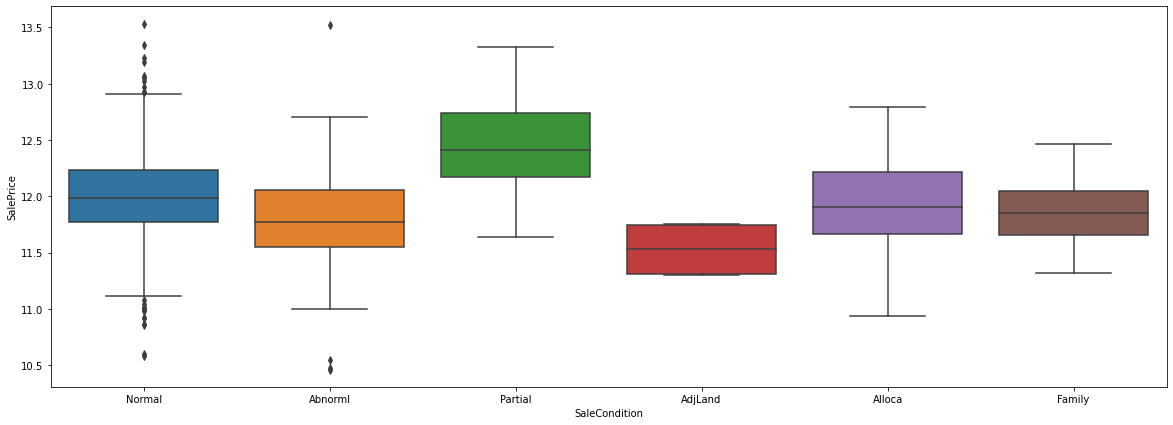

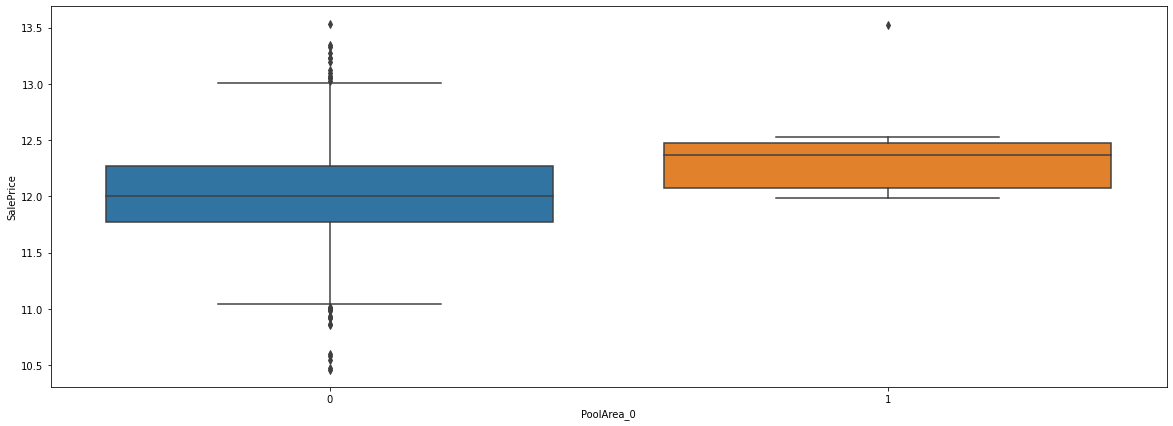

In [145]:
for idx,col in enumerate(catlist):
  plt.figure(figsize=(20,7))
  sns.boxplot(x=col, y="SalePrice", data=data)
  plt.show()

In [146]:
train_test_int=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(train_test[intlist]))
train_test_int.columns=train_test[intlist].columns
train_test_cat=train_test[catlist]
train_test_cat.reset_index(drop=True,inplace=True)
train_test_dummy=pd.get_dummies(train_test_cat,columns=catlist)
train_test_base=pd.concat([train_test_dummy,train_test_int],axis=1)
data_base=train_test_base[:1460]
test_base=train_test_base[1460:]
data=train_test[:1460]
test=train_test[1460:]
data_dummy=train_test_dummy[:1460]
test_dummy=train_test_dummy[1460:]

In [203]:
test_base

,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,KitchenAbvGr_0,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,HalfBath_0,HalfBath_1,HalfBath_2,WoodDeckSF_0_0,WoodDeckSF_0_1,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_thena,Street_Grvl,Street_Pave,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_thena,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_thena,BsmtFullBath_0.0,BsmtFullBath_1.0,...,SaleType_Oth,SaleType_WD,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,BsmtFinSF1_0_0,BsmtFinSF1_0_1,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PoolArea_0_0,PoolArea_0_1,LotFrontage,LotArea,YearRemodAdd,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,totalsf,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,totalporch,Total_Bathrooms
1460,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0.202055,0.048246,0.816667,0.355072,0.00000,0.082920,0.115582,0.144354,0.118042,0.000000,0.126467,0.105878,0.490591,0.098315,0.000000,0.0,0.208333,0.099420,0.000000
1461,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0.205479,0.060609,0.866667,0.376812,0.06750,0.163536,0.173801,0.217512,0.208990,0.000000,0.203538,0.187453,0.209677,0.275983,0.048518,0.0,0.000000,0.029826,0.083333
1462,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0.181507,0.058566,0.200000,0.094203,0.00000,0.140149,0.058647,0.151882,0.124764,0.339467,0.194693,0.243971,0.323925,0.148876,0.045822,0.0,0.000000,0.028169,0.250000
1463,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0.195205,0.040562,0.200000,0.086957,0.01250,0.106662,0.138699,0.151555,0.124344,0.328329,0.192328,0.239261,0.315860,0.252809,0.048518,0.0,0.000000,0.029826,0.250000
1464,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0.075342,0.017318,0.300000,0.130435,0.00000,0.046598,0.435360,0.209493,0.198698,0.000000,0.194955,0.178222,0.340054,0.000000,0.110512,0.0,0.250000,0.187241,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0.000000,0.002973,0.666667,0.289855,0.00000,0.000000,0.233733,0.089362,0.044528,0.264407,0.114206,0.142803,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.083333
2915,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0.000000,0.002776,0.666667,0.289855,0.00000,0.044649,0.125856,0.089362,0.044528,0.264407,0.114206,0.142803,0.192204,0.000000,0.032345,0.0,0.000000,0.019884,0.083333
2916,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0.476027,0.087406,0.233333,0.362319,0.00000,0.216867,0.000000,0.200327,0.186936,0.000000,0.185146,0.167671,0.387097,0.332865,0.000000,0.0,0.000000,0.000000,0.166667
2917,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0.140411,0.042726,0.

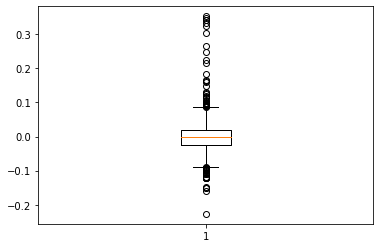

In [147]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(data_base,y)
ypred=lgbm.predict(data_base)
residual=ypred-y
fig = plt.boxplot(residual)
data_base['res']=residual
data_base['y']=y
data_base=data_base[(data_base['res']<0.2) & (data_base['res']>-0.2)]
y=data_base['y']
data_base.drop(['res','y'],axis=1,inplace=True)

In [148]:
lgbm = lgb.LGBMRegressor()
kf=KFold(n_splits=5, random_state=23, shuffle=True)
scores = cross_val_score(lgbm,data_base,y,scoring='neg_mean_squared_error',cv=kf)
print(-round(scores.mean(),5))
base=-round(scores.mean(),5)

0.01151


In [149]:
scorelist=[]
for idx,col in enumerate(catlist):
  col_dummy=pd.get_dummies(data[col],columns=col)
  data_for=data_base.copy()
  for col2 in col_dummy.columns:
    for col3 in data_dummy.columns:
      name=str(col2)+'*'+str(col3)
      data_for[name]=col_dummy[col2]*data_dummy[col3]

  lgbm = lgb.LGBMRegressor()
  kf=KFold(n_splits=5, random_state=23, shuffle=True)
  scores = cross_val_score(lgbm,data_for,y,scoring='neg_mean_squared_error',cv=kf)
  scorelist.append(-round(scores.mean(),5))

In [150]:
idxlist=[]

for idx,i in enumerate(scorelist):
  if(i<base):
    idxlist.append(idx)

len(idxlist)

24

In [180]:
data_for=data_base.copy()
for idx in idxlist:
  col_dummy=pd.get_dummies(data[catlist[idx]],columns=catlist[idx])
  col_dummy.reset_index(drop=True,inplace=True)
  for col2 in col_dummy.columns:
    for col3 in data_dummy.columns:
      name=str(col2)+'*'+str(col3)
      data_for[name]=col_dummy[col2]*data_dummy[col3]

data_for.shape

(1421, 28936)

In [204]:
test_for=test_base.copy()
test_dummy.reset_index(drop=True,inplace=True)
test_for.reset_index(drop=True,inplace=True)
for idx in idxlist:
  col_dummy=pd.get_dummies(test[catlist[idx]],columns=catlist[idx])
  col_dummy.reset_index(drop=True,inplace=True)
  for col2 in col_dummy.columns:
    for col3 in test_dummy.columns:
      name=str(col2)+'*'+str(col3)
      test_for[name]=col_dummy[col2]*test_dummy[col3]

test_for.shape

(1459, 25723)

In [206]:
lgbm = lgb.LGBMRegressor()
kf=KFold(n_splits=5, random_state=23, shuffle=True)
scores = cross_val_score(lgbm,data_for,y,scoring='neg_mean_squared_error',cv=kf)
print(-round(scores.mean(),5))
lgbm.fit(data_for,y)

feature_importance = pd.DataFrame({'feature_name':data_for.columns,'importance':lgbm.feature_importances_} )
feature_importance.sort_values(by='importance',ascending=False,inplace=True)
valist=[100,300,500]
for num in valist:
  x_final_select=data_for[feature_importance.iloc[:num,0]]
  x_test_select=test_for[feature_importance.iloc[:num,0]]
  lgbm = lgb.LGBMRegressor(max_depth=5,min_child_samples=60,subsample=0.5,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2) 
  
  scores = cross_val_score(lgbm,x_final_select,y,scoring='neg_mean_squared_error',cv=kf)
  print(num,-round(scores.mean(),5))

100 0.01324
300 0.01296
500 0.01296


In [155]:
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model,x_final_select,y,scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [225]:
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

lightgbm = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01,max_depth=4,min_child_samples=60,subsample=0.5,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2)
xgboost = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.01,max_depth=4,subsample=0.7,colsample_bytree=0.7,reg_alpha=0.00005)
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 5, 10, 15, 20, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))
rf = RandomForestRegressor(n_estimators=1000,max_depth=4,min_samples_split=5,min_samples_leaf=5,)

estimators = [('lgb', lightgbm),('xgb', xgboost),('ridge',ridge),('rf',rf)]
reg = StackingRegressor(estimators=estimators,final_estimator=lightgbm,cv=kf,passthrough=True)

In [ ]:
print(cv_rmse(lightgbm))
print(cv_rmse(xgboost))
print(cv_rmse(ridge))
print(cv_rmse(rf))
print(cv_rmse(reg))

In [ ]:
reg.fit(data_base,y)
out=pd.DataFrame(np.expm1(reg.predict(test_base)))

In [227]:
out.describe()

,0
count,1459.000000
mean,177985.052422
std,73603.704229
min,81861.064345
25%,128888.859033
50%,157000.003747
75%,207534.819139
max,411972.180102


In [ ]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
sample_submission['SalePrice']=out
sample_submission.to_csv('upload.csv',index=False)
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f upload.csv -m "upload"